In [1]:
import os
import sys
sys.path.append("../")

import math
import random
from scipy import special
import numpy as np
import torch
# import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sympy import *
import sympy as sp
import scipy.special as special
from scipy.integrate import quad

mu = 0.05
dim = 1 

def u0(x):
    return sin(np.pi*x)

# x = sp.Symbol("x").float()
# x=x.float()

def v0(x):
    z = sp.Symbol("z")
    return integrate(u0(z), (z, 0, x))

def w(x,mu):
    return exp(-v0(x)/2/mu)

c=[quad(w,0,1,args=(mu))[0]]

def w0(x,k,mu):
    return exp(-v0(x)/2/mu)*cos(k*np.pi*x)

nb_sums=14;    

for k in range(1,nb_sums):
    c.append(2*quad(w0,0,1,args=(k,mu))[0])
    
def exact_example(t, x, T):
    xi = (1+sum(x))/2
    if t==T: 
        return np.sin(np.pi*xi)
    else:
        sum1 = 0  
        for n in range(1,nb_sums):
            sum1 += c[n]*n*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.sin(n*np.pi*xi)
        sum2 = 0
        for n in range(1,nb_sums):
            sum2 += c[n]*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.cos(n*np.pi*xi)
        return 2*np.pi*mu*sum1/(c[0]+sum2)


In [3]:
nu=mu*4

def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) 
  
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) + nu*y[(dim+1):(2*dim+1)].sum(dim=0)

def phi_example(x, coordinate=0):
    return torch.sin(torch.pi*(1+x.sum(axis=0))/2)

# def exact_example(t, x, T):
#    xi = T-t + x.sum(axis=0)
#    return np.sin(np.pi*(1+xi)/2)

def boundary_fun(x, coordinate=0):
    return torch.tensor(np.zeros(x.size()[1]), device=device).to(torch.float32)

t_lo, x_lo, x_hi = 0., -1, 1
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

In [4]:
# Conditional probability to survive
# Set boundary of DB and BSDE methods
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-1,
    upper_bound=1,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=x_lo, upper_bound=x_hi):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## dim = 1

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4


Patch 0: generation of u samples take 0.8849680423736572 seconds.


Generating batch 4/4


Patch  0: epoch    0 with loss 1.37E+00


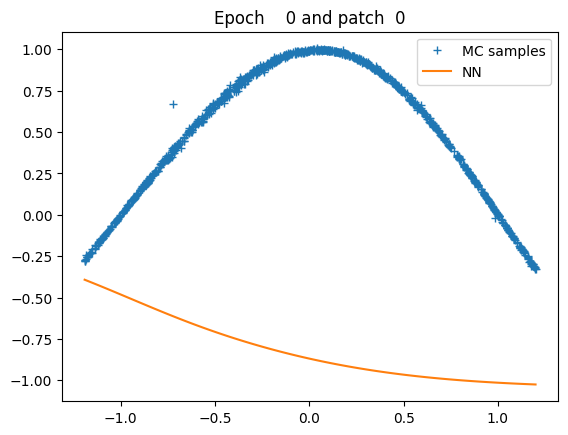

Patch  0: epoch  500 with loss 1.44E-04


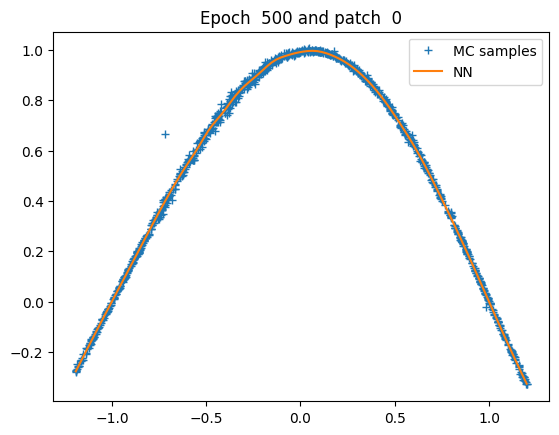

Patch  0: epoch 1000 with loss 9.54E-04


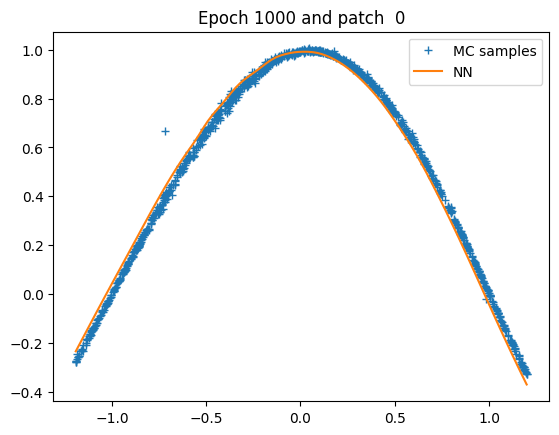

Patch  0: epoch 1500 with loss 1.44E-04


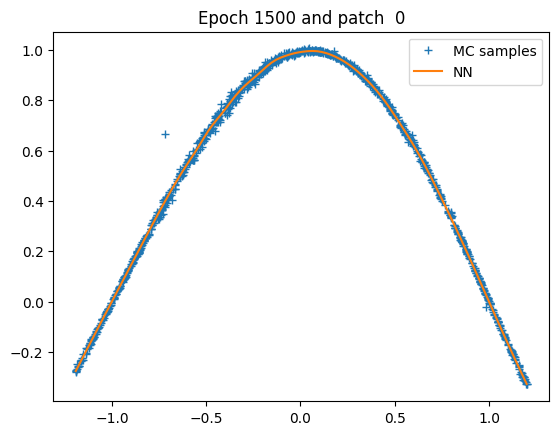

Patch  0: epoch 2000 with loss 1.44E-04


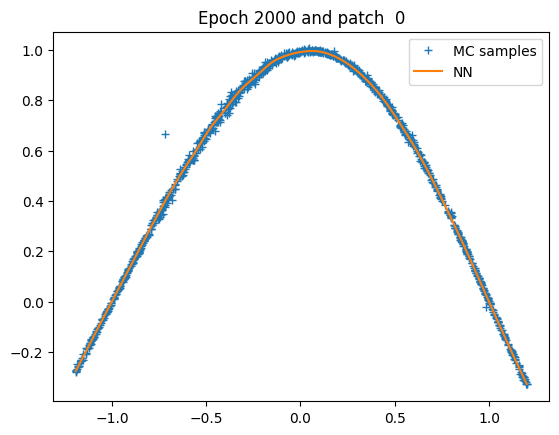

Patch  0: epoch 2499 with loss 1.44E-04


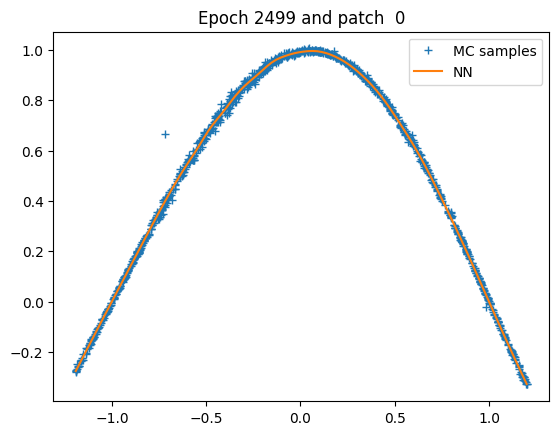

Patch 0: training of u with 2500 epochs take 20.982619524002075 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 1: generation of u samples take 4.459447145462036 seconds.
Patch  1: epoch    0 with loss 2.19E+00


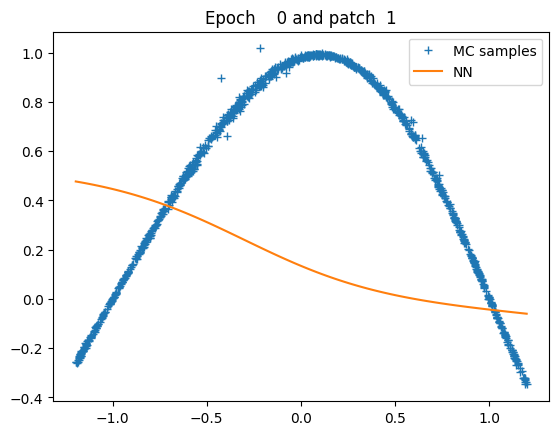

Patch  1: epoch  500 with loss 1.30E-04


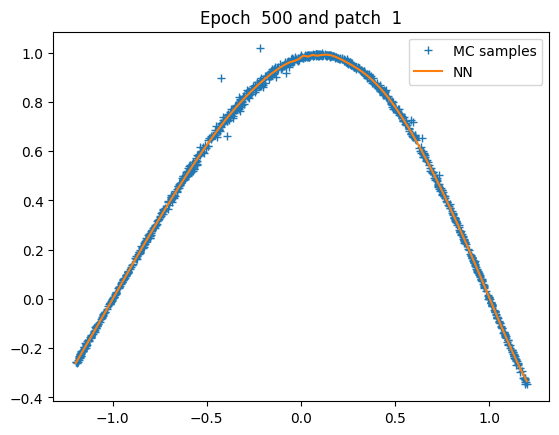

Patch  1: epoch 1000 with loss 1.34E-04


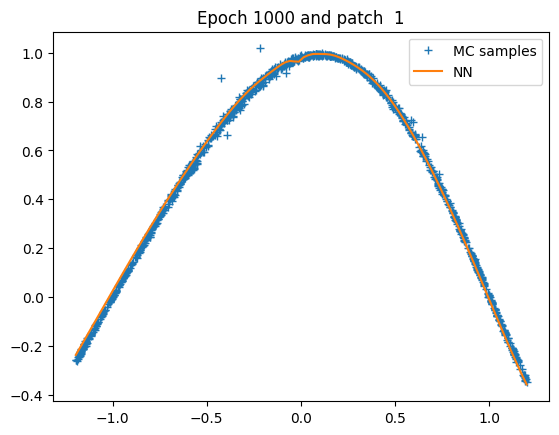

Patch  1: epoch 1500 with loss 1.29E-04


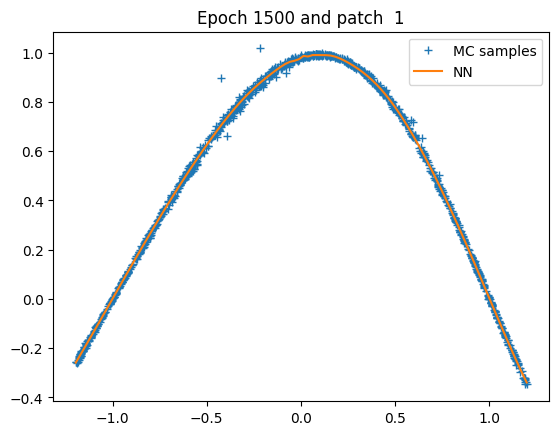

Patch  1: epoch 2000 with loss 1.29E-04


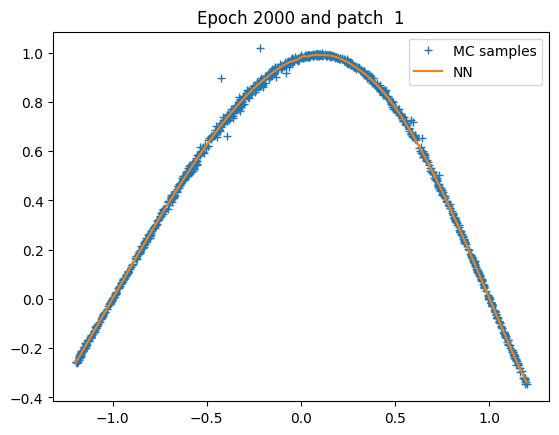

Patch  1: epoch 2499 with loss 1.29E-04


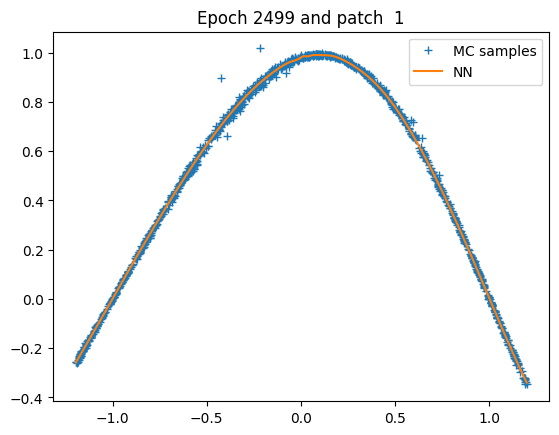

Patch 1: training of u with 2500 epochs take 19.394073009490967 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 2: generation of u samples take 3.6100854873657227 seconds.
Patch  2: epoch    0 with loss 1.60E+00


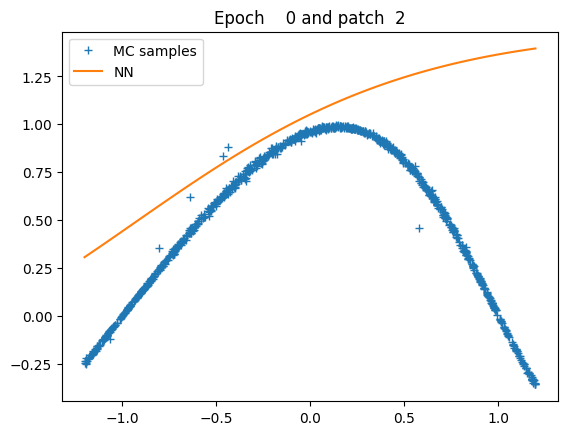

Patch  2: epoch  500 with loss 2.61E-04


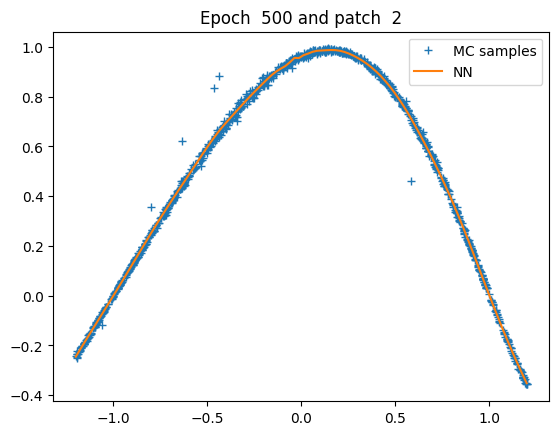

Patch  2: epoch 1000 with loss 2.62E-04


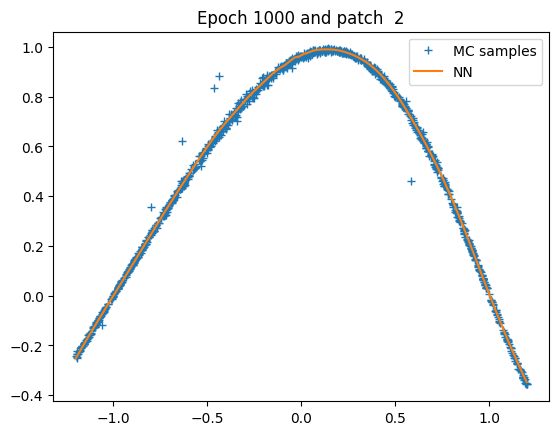

Patch  2: epoch 1500 with loss 2.59E-04


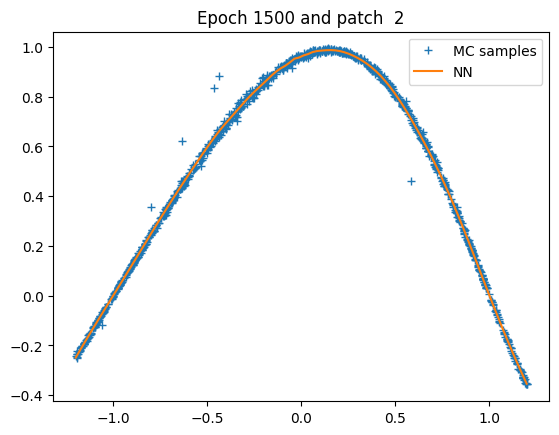

Patch  2: epoch 2000 with loss 2.59E-04


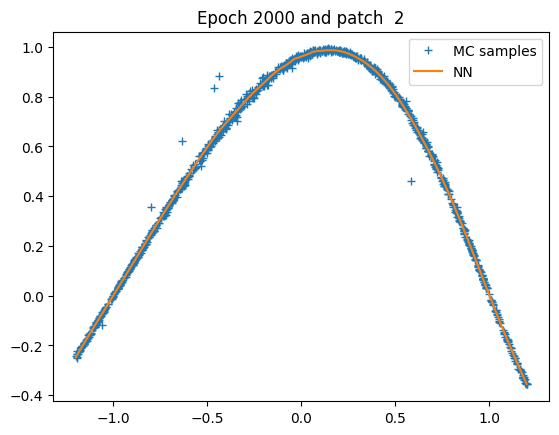

Patch  2: epoch 2499 with loss 2.59E-04


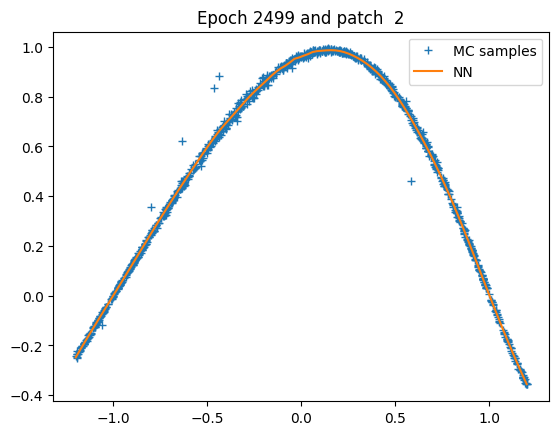

Patch 2: training of u with 2500 epochs take 19.355939865112305 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 3: generation of u samples take 3.8068244457244873 seconds.
Patch  3: epoch    0 with loss 3.70E+00


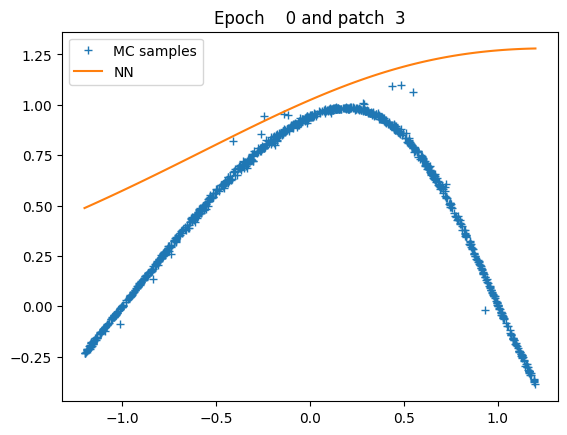

Patch  3: epoch  500 with loss 3.26E-04


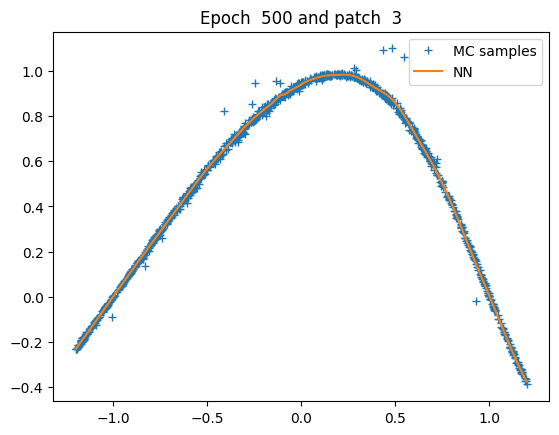

Patch  3: epoch 1000 with loss 3.24E-04


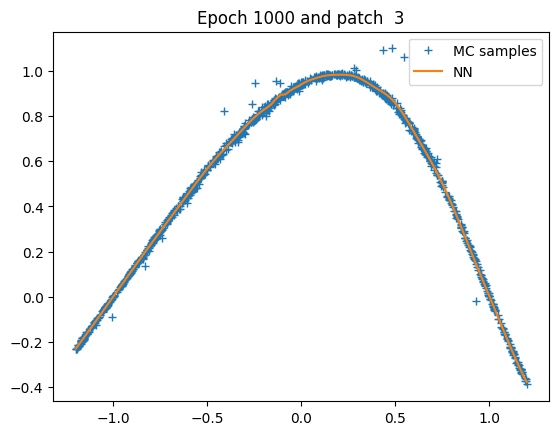

Patch  3: epoch 1500 with loss 3.24E-04


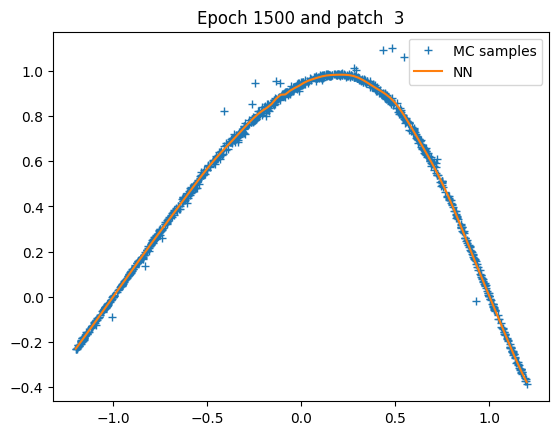

Patch  3: epoch 2000 with loss 3.24E-04


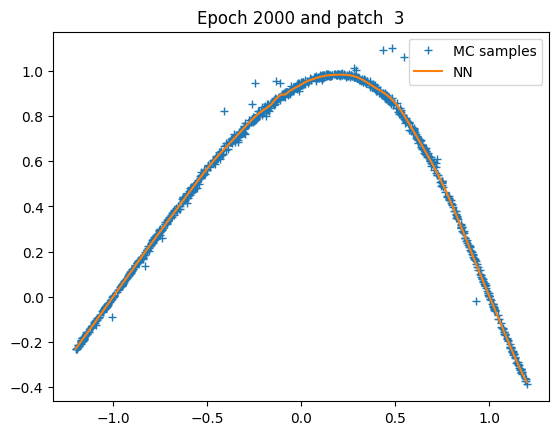

Patch  3: epoch 2499 with loss 3.24E-04


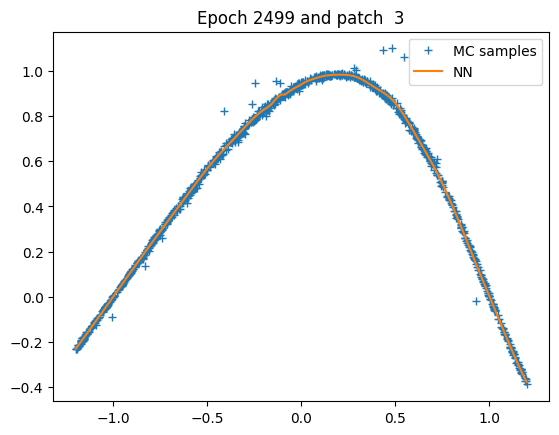

Patch 3: training of u with 2500 epochs take 19.689454793930054 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 95 seconds; L1 error: 1.84E-02; L2 error: 4.91E-04; rel error: INF.
fdb runtime: 0 seconds; total runtime: 95 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


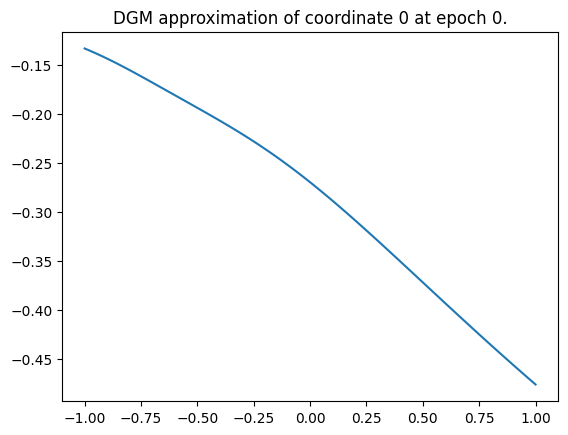

Epoch 0 with loss 1.6866892576217651


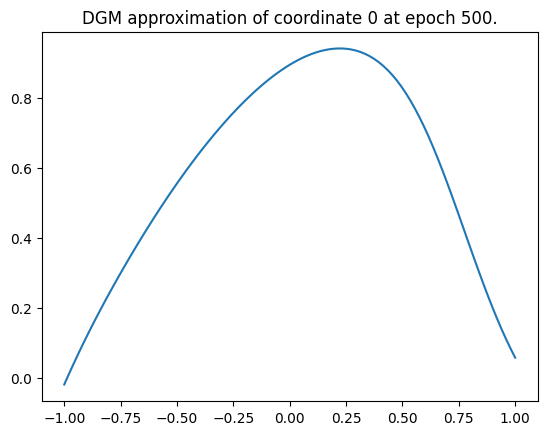

Epoch 500 with loss 0.002306610345840454


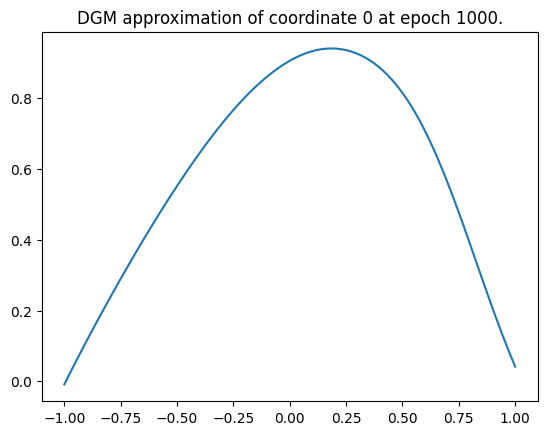

Epoch 1000 with loss 0.0009403434814885259


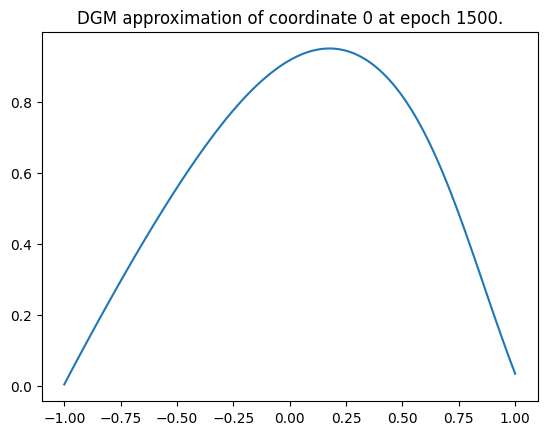

Epoch 1500 with loss 0.0007164202397689223


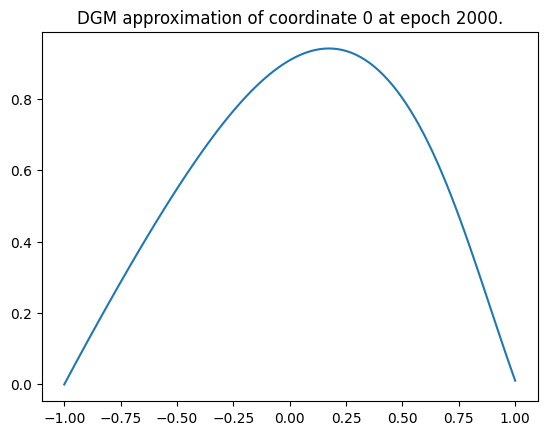

Epoch 2000 with loss 0.0007256774115376174


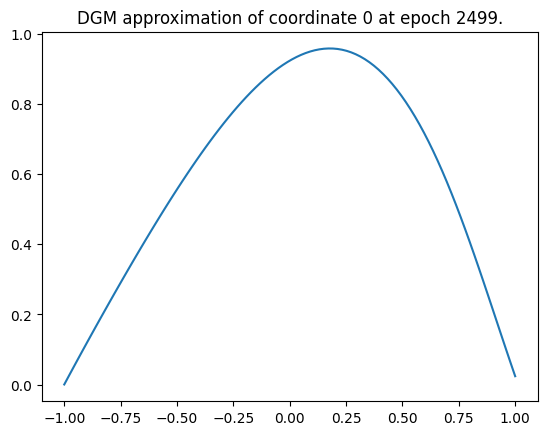

Epoch 2499 with loss 0.0004228994366712868
Training of neural network with 2500 epochs take 90.22290706634521 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 90 seconds; L1 error: 5.75E-03; L2 error: 4.32E-05; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


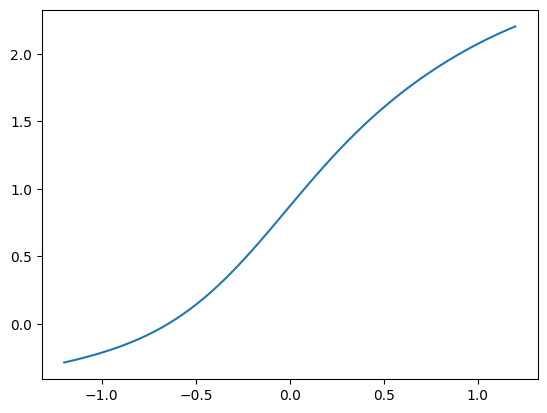

Epoch 0 with loss 1.0930671691894531


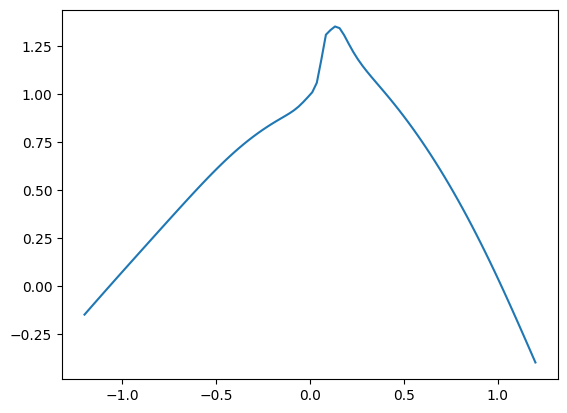

Epoch 500 with loss 0.0007761787273921072


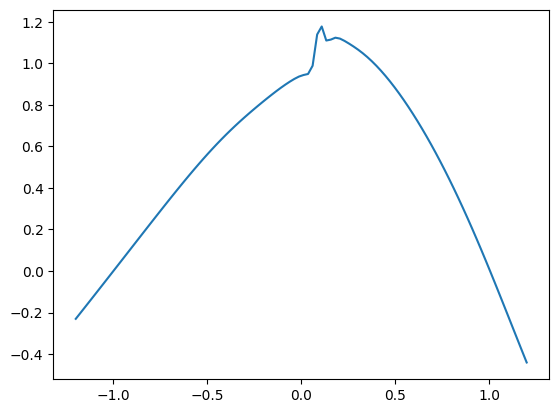

Epoch 1000 with loss 0.00024181157641578466


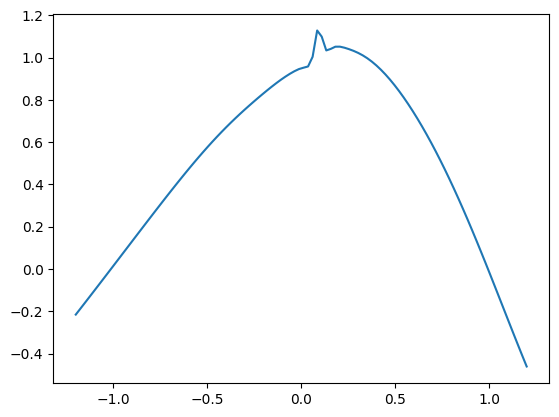

Epoch 1500 with loss 0.0006705267587676644


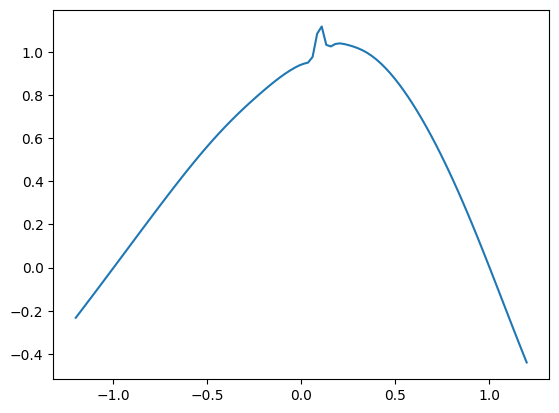

Epoch 2000 with loss 0.0006463128374889493


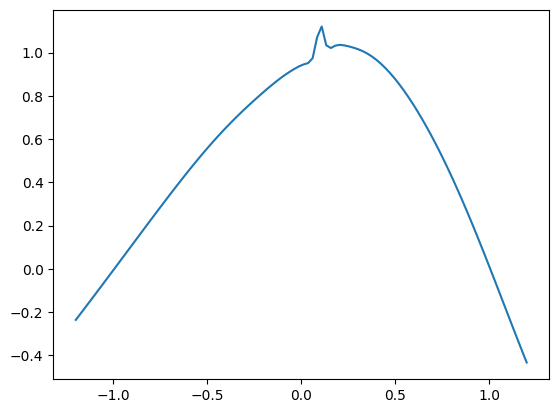

Epoch 2499 with loss 0.000729849620256573
Training of neural network with 2500 epochs take 140.98844361305237 seconds.
Time taken: 141 seconds; L1 error: 3.20E-02; L2 error: 2.17E-03; rel error: INF.




######## Summary for deep branching method
runtime:        95
fdb runtime:    0
total runtime:  95
mean L1 error:  1.84E-02
std L1 error:   0.00E+00
mean L2 error:  4.91E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        90
mean L1 error:  5.75E-03
std L1 error:   0.00E+00
mean L2 error:  4.32E-05
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  3.20E-02
std L1 error:   0.00E+00
mean L2 error:  2.17E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


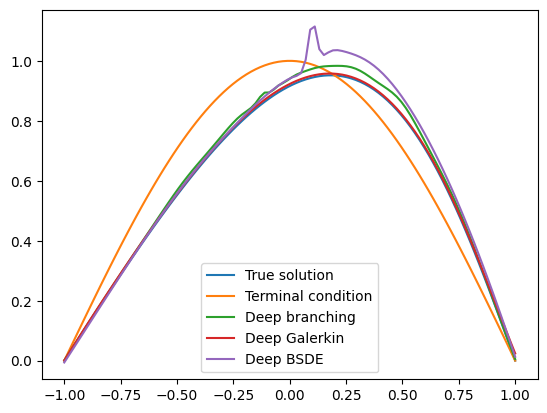

In [5]:
dim = 1
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=4, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 2

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 11.489355087280273 seconds.
Patch  0: epoch    0 with loss 8.94E-01


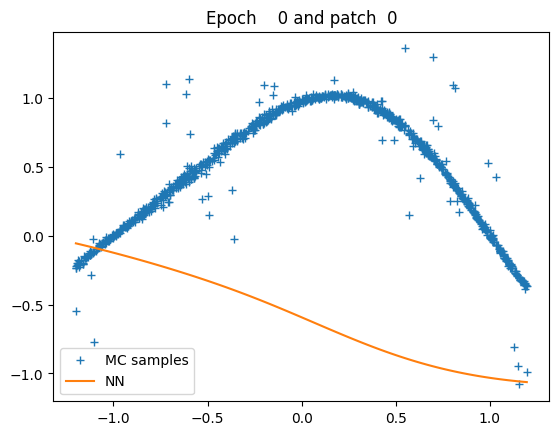

Patch  0: epoch  500 with loss 8.65E-03


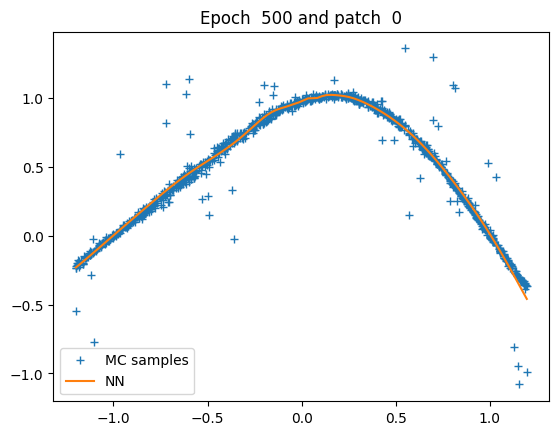

Patch  0: epoch 1000 with loss 8.62E-03


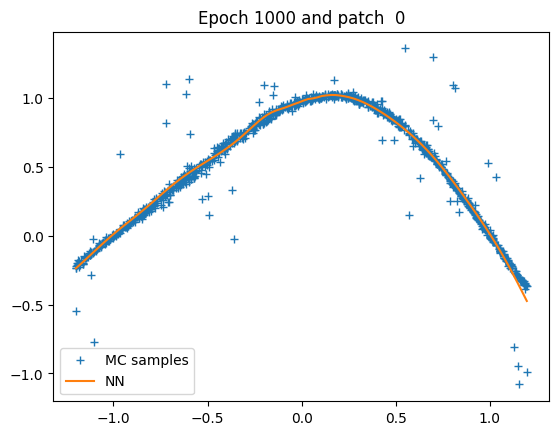

Patch  0: epoch 1500 with loss 8.62E-03


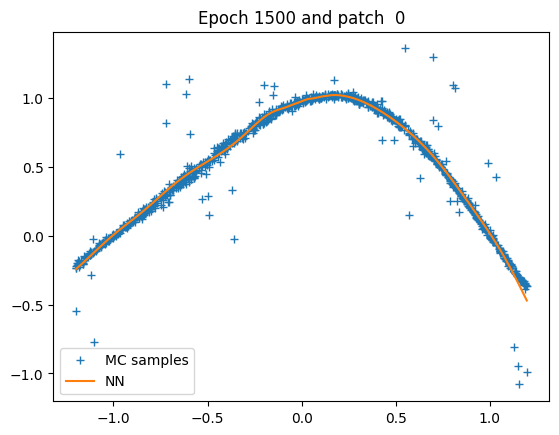

Patch  0: epoch 2000 with loss 8.60E-03


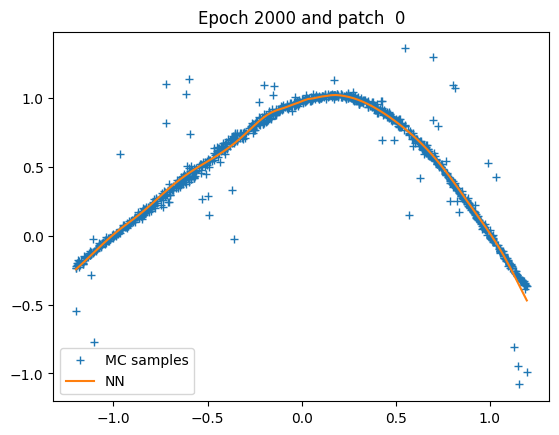

Patch  0: epoch 2499 with loss 8.60E-03


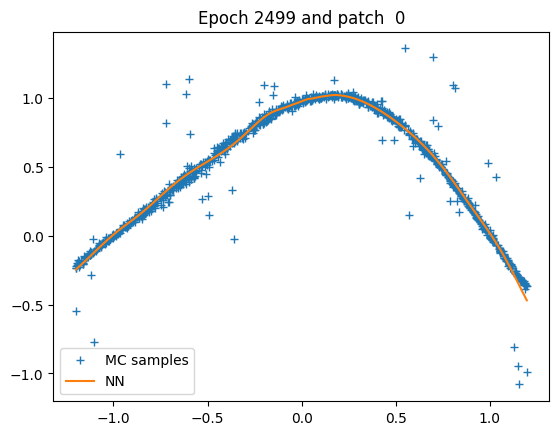

Patch 0: training of u with 2500 epochs take 16.358630418777466 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 28 seconds; L1 error: 2.45E-02; L2 error: 1.10E-03; rel error: INF.
fdb runtime: 0 seconds; total runtime: 28 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


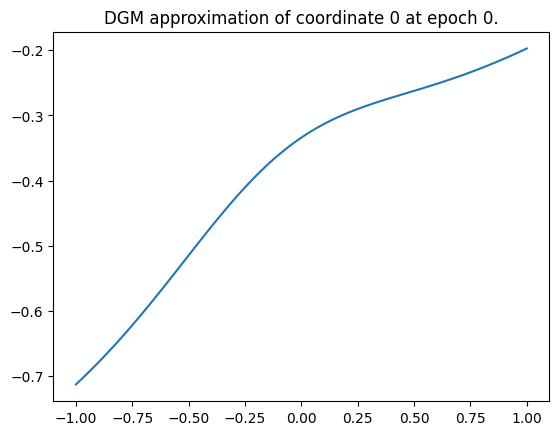

Epoch 0 with loss 3.264504909515381


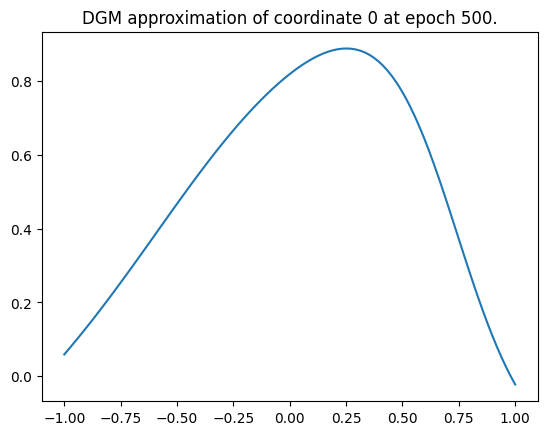

Epoch 500 with loss 0.1398749202489853


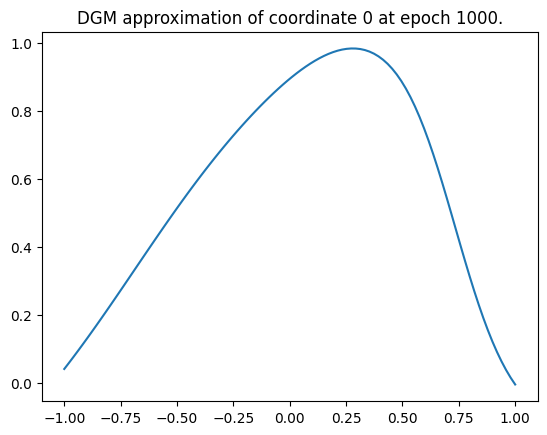

Epoch 1000 with loss 0.11502330005168915


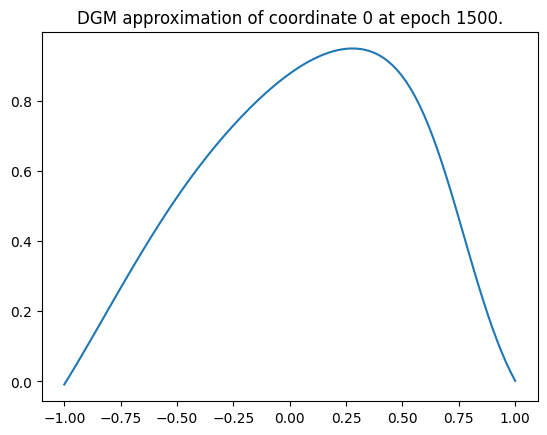

Epoch 1500 with loss 0.10486400127410889


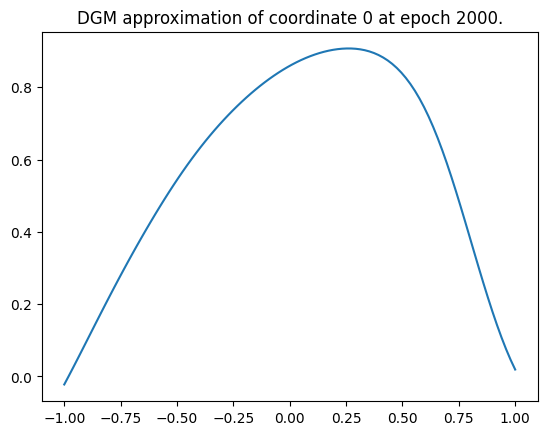

Epoch 2000 with loss 0.08666371554136276


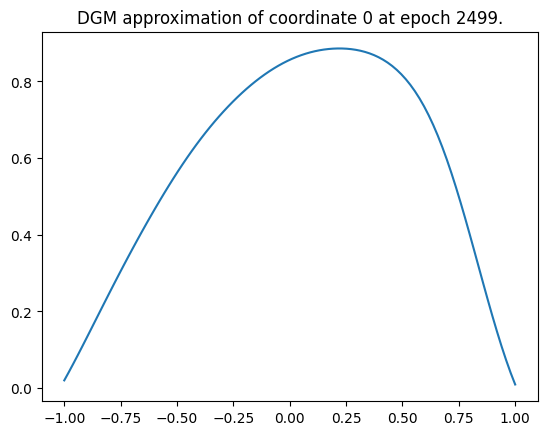

Epoch 2499 with loss 0.0767781138420105
Training of neural network with 2500 epochs take 131.16677618026733 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 131 seconds; L1 error: 2.66E-02; L2 error: 1.11E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


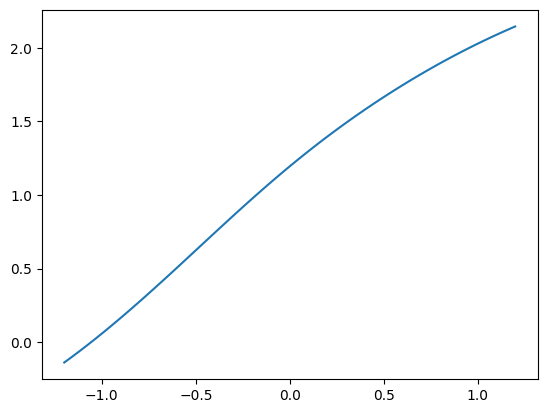

Epoch 0 with loss 1.70512056350708


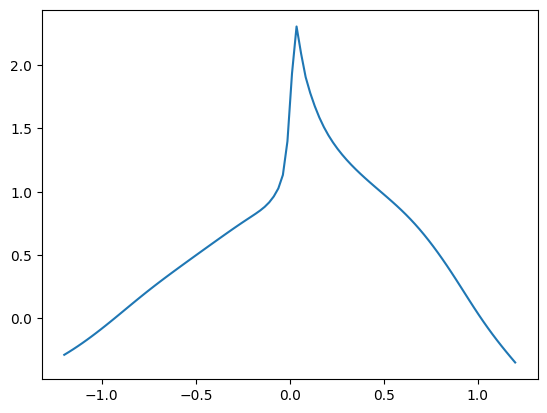

Epoch 500 with loss 0.0031576608307659626


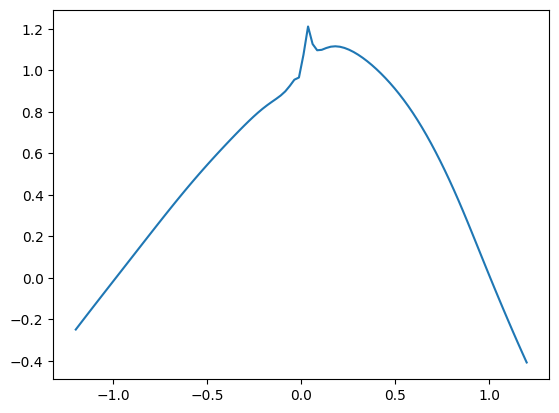

Epoch 1000 with loss 0.0009170620469376445


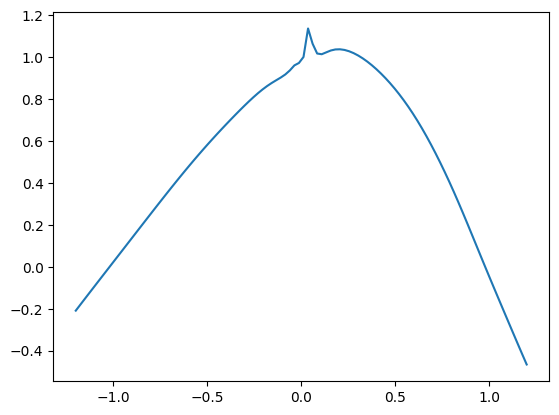

Epoch 1500 with loss 0.00035012722946703434


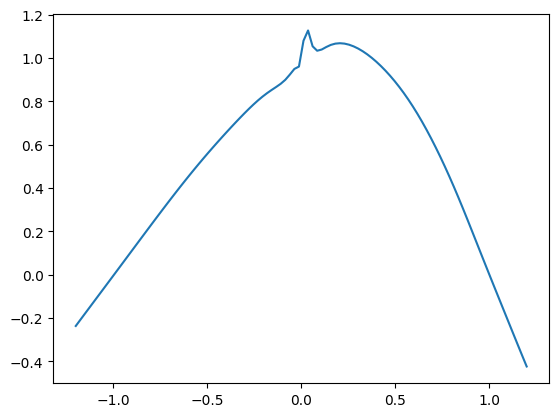

Epoch 2000 with loss 0.00029720281600020826


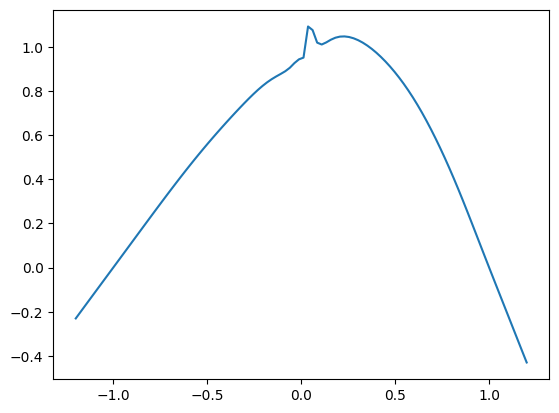

Epoch 2499 with loss 0.00045478870742954314
Training of neural network with 2500 epochs take 141.7765064239502 seconds.
Time taken: 142 seconds; L1 error: 3.53E-02; L2 error: 2.61E-03; rel error: INF.




######## Summary for deep branching method
runtime:        28
fdb runtime:    0
total runtime:  28
mean L1 error:  2.45E-02
std L1 error:   0.00E+00
mean L2 error:  1.10E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        131
mean L1 error:  2.66E-02
std L1 error:   0.00E+00
mean L2 error:  1.11E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  3.53E-02
std L1 error:   0.00E+00
mean L2 error:  2.61E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


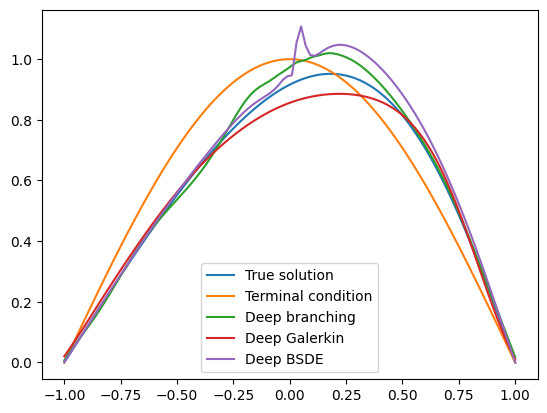

In [6]:
dim = 2
T=0.1/dim

grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 3

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 20.526875495910645 seconds.
Patch  0: epoch    0 with loss 2.88E+00


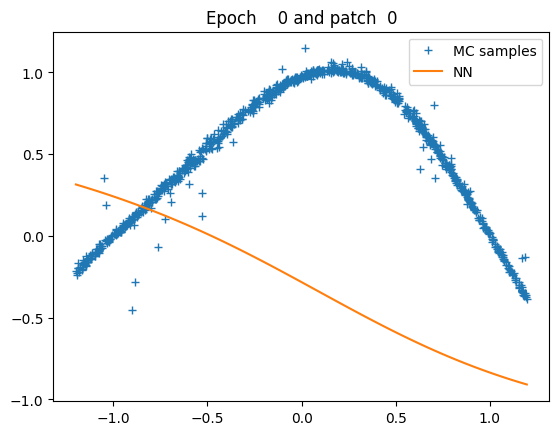

Patch  0: epoch  500 with loss 1.70E-03


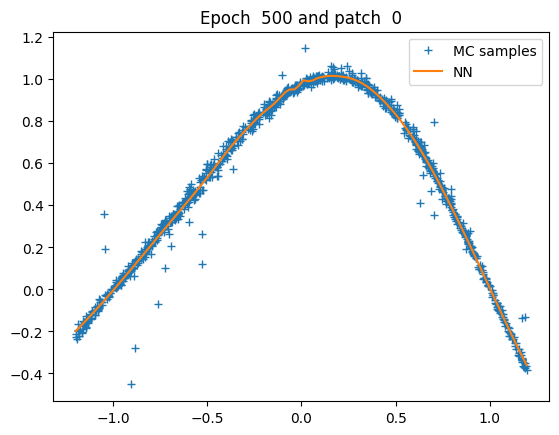

Patch  0: epoch 1000 with loss 1.69E-03


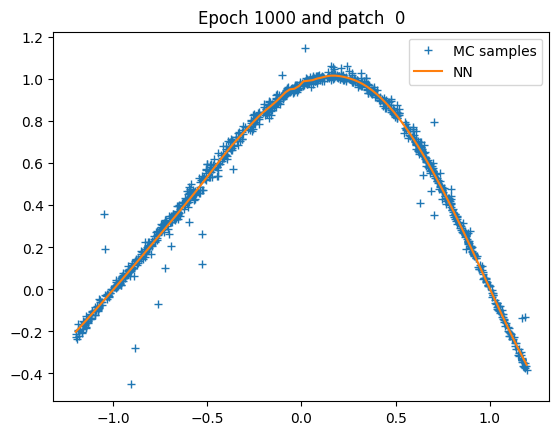

Patch  0: epoch 1500 with loss 1.69E-03


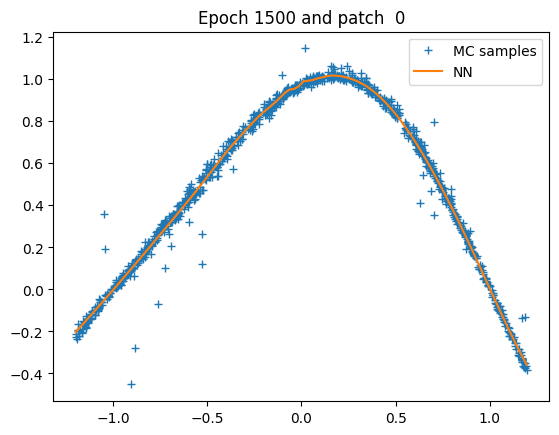

Patch  0: epoch 2000 with loss 1.69E-03


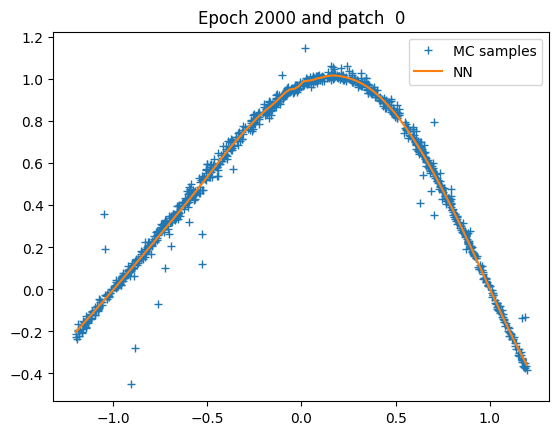

Patch  0: epoch 2499 with loss 1.69E-03


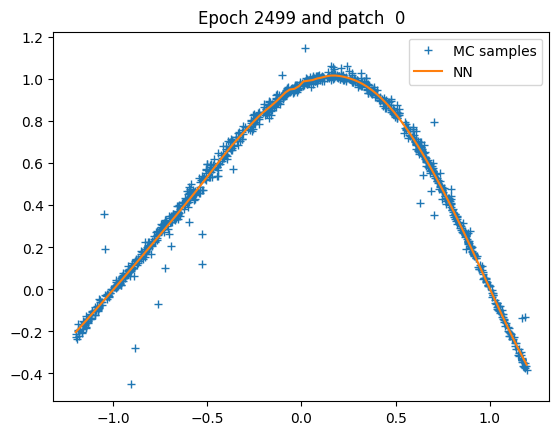

Patch 0: training of u with 2500 epochs take 17.16447138786316 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 36 seconds; L1 error: 2.76E-02; L2 error: 1.20E-03; rel error: INF.
fdb runtime: 1 seconds; total runtime: 38 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


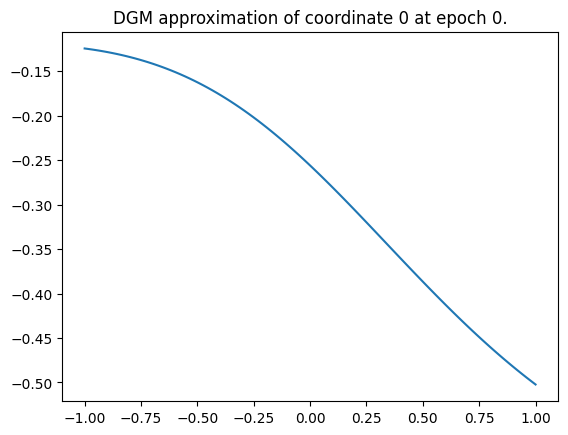

Epoch 0 with loss 1.5646770000457764


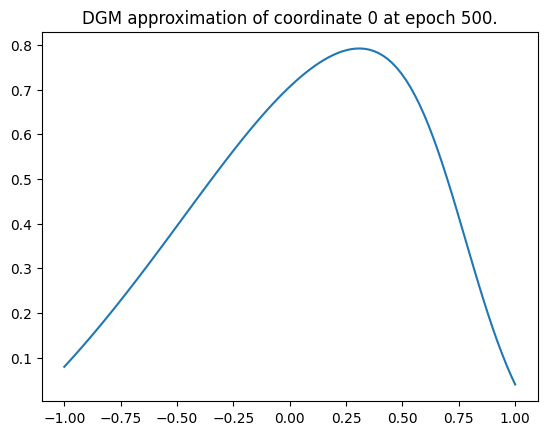

Epoch 500 with loss 0.205738827586174


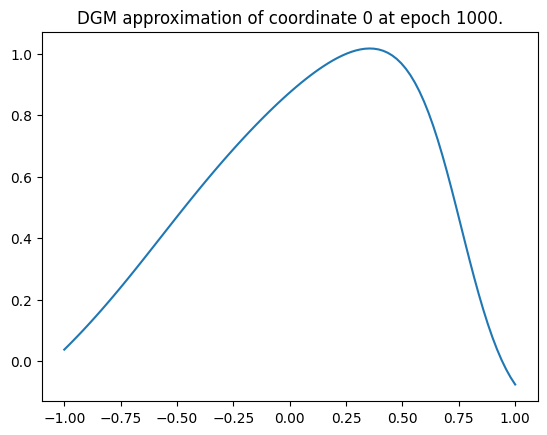

Epoch 1000 with loss 0.1789764165878296


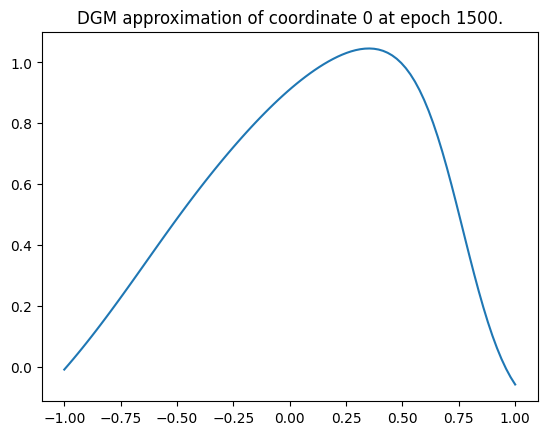

Epoch 1500 with loss 0.16879019141197205


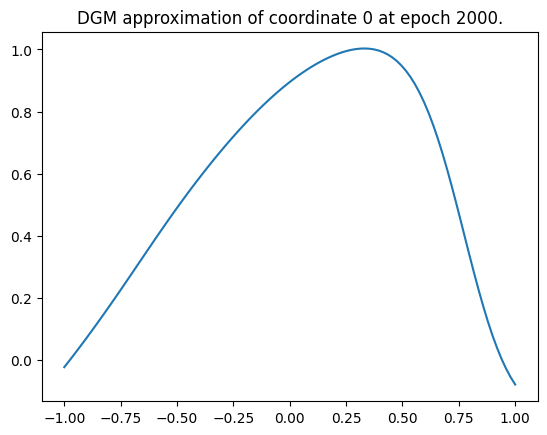

Epoch 2000 with loss 0.15181809663772583


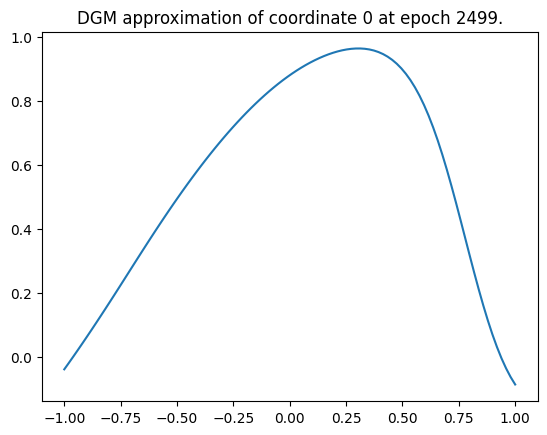

Epoch 2499 with loss 0.14132556319236755
Training of neural network with 2500 epochs take 170.81386542320251 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 171 seconds; L1 error: 5.63E-02; L2 error: 3.98E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


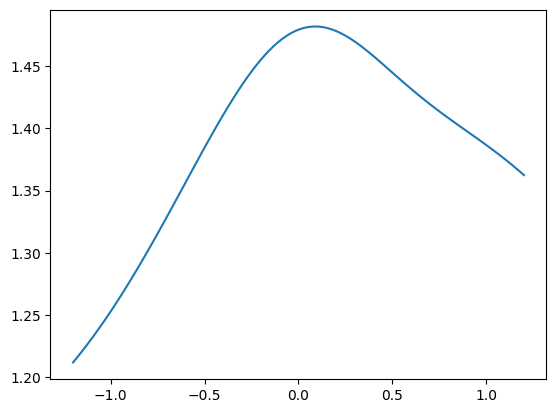

Epoch 0 with loss 1.3048616647720337


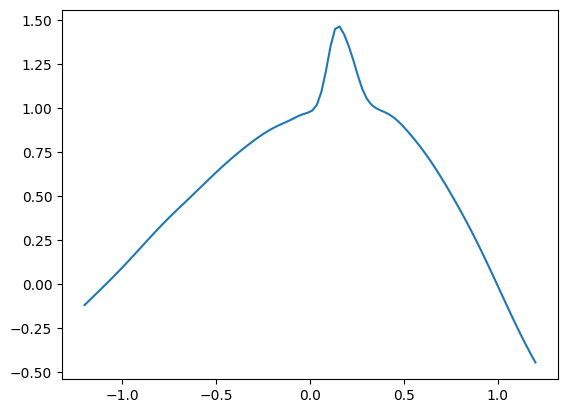

Epoch 500 with loss 0.002552369609475136


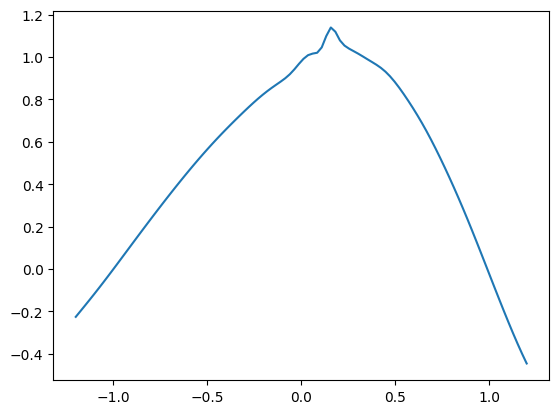

Epoch 1000 with loss 0.0007231358904391527


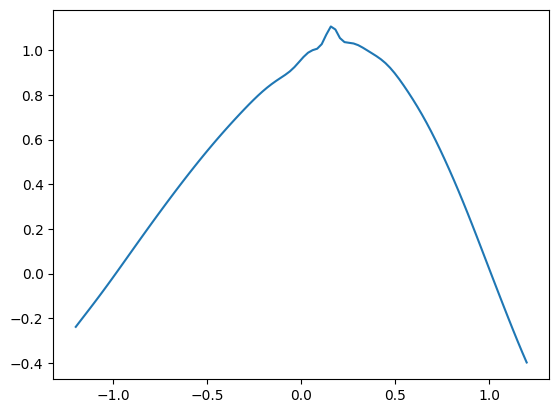

Epoch 1500 with loss 0.0016564169200137258


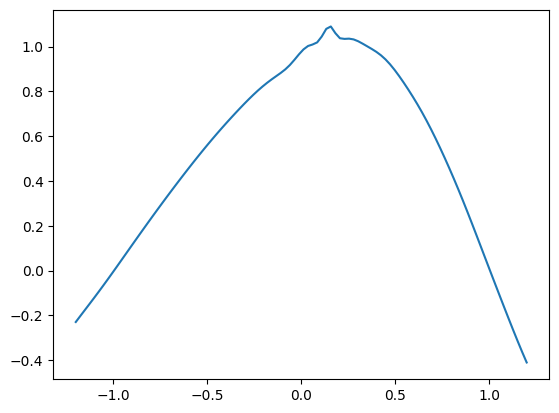

Epoch 2000 with loss 0.00027329844306223094


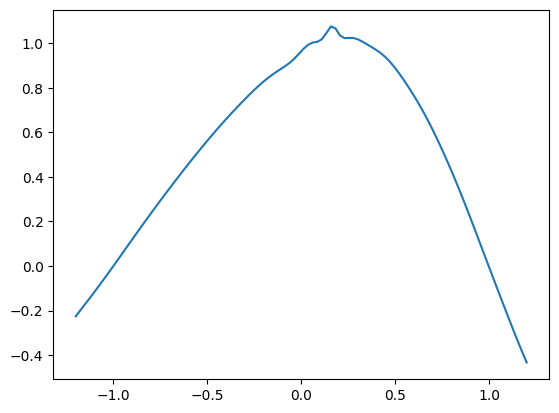

Epoch 2499 with loss 0.0004584534908644855
Training of neural network with 2500 epochs take 142.31077671051025 seconds.
Time taken: 142 seconds; L1 error: 3.45E-02; L2 error: 2.18E-03; rel error: INF.




######## Summary for deep branching method
runtime:        36
fdb runtime:    1
total runtime:  38
mean L1 error:  2.76E-02
std L1 error:   0.00E+00
mean L2 error:  1.20E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        171
mean L1 error:  5.63E-02
std L1 error:   0.00E+00
mean L2 error:  3.98E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  3.45E-02
std L1 error:   0.00E+00
mean L2 error:  2.18E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


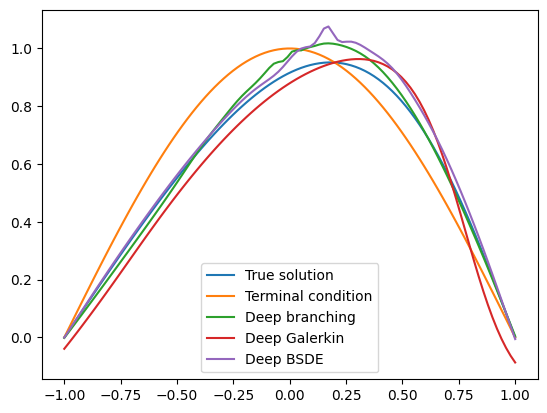

In [7]:
dim = 3
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 4

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 35.8769474029541 seconds.
Patch  0: epoch    0 with loss 4.63E-01


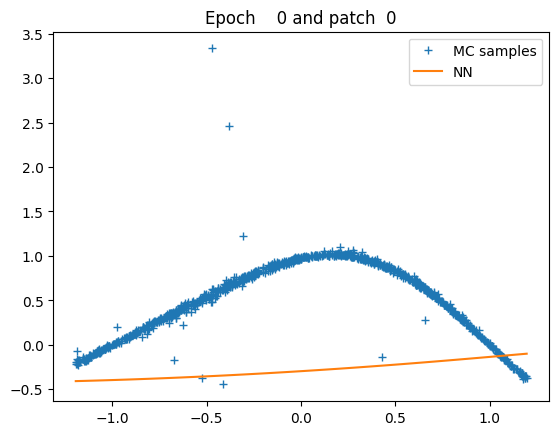

Patch  0: epoch  500 with loss 1.49E-02


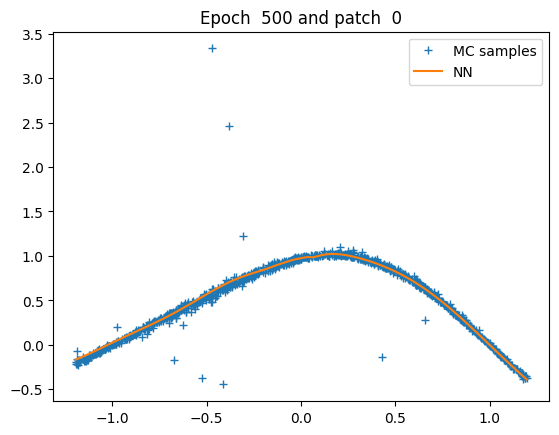

Patch  0: epoch 1000 with loss 1.48E-02


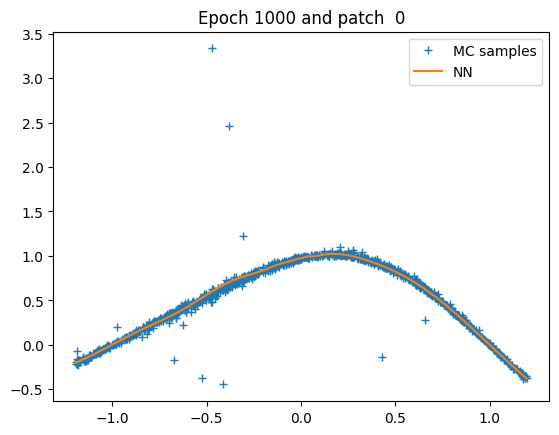

Patch  0: epoch 1500 with loss 1.48E-02


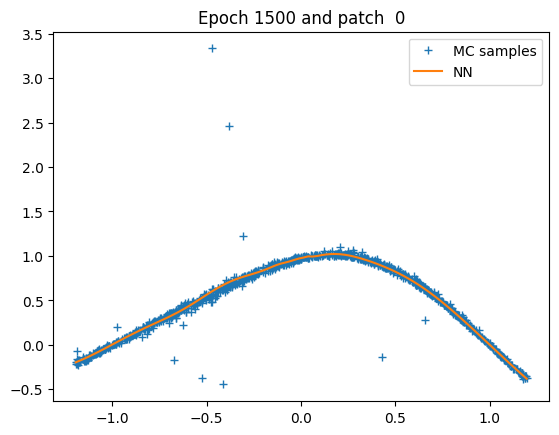

Patch  0: epoch 2000 with loss 1.48E-02


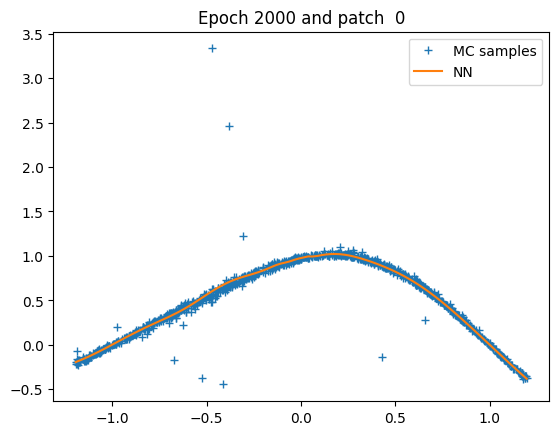

Patch  0: epoch 2499 with loss 1.48E-02


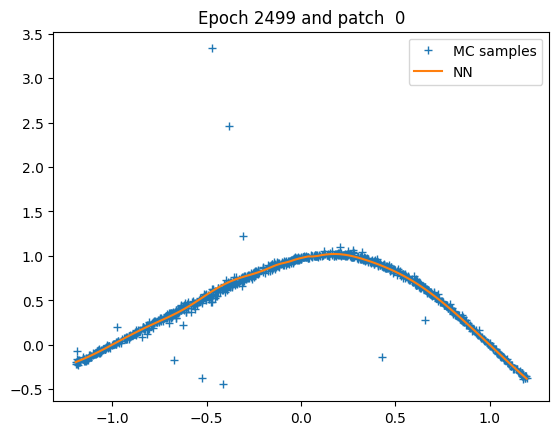

Patch 0: training of u with 2500 epochs take 16.786683797836304 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 48 seconds; L1 error: 2.59E-02; L2 error: 1.14E-03; rel error: INF.
fdb runtime: 5 seconds; total runtime: 53 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


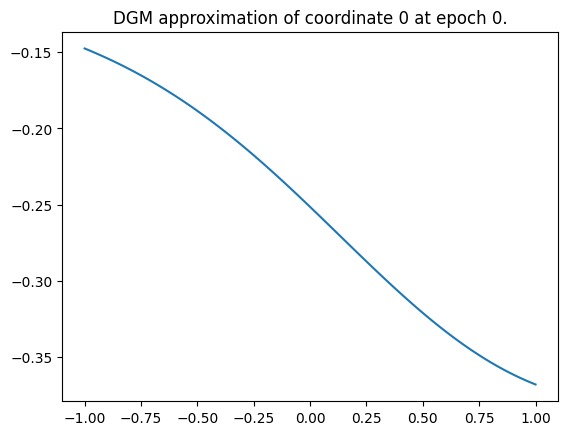

Epoch 0 with loss 1.115968942642212


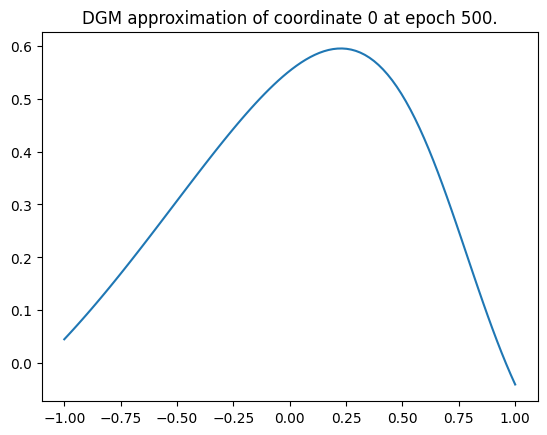

Epoch 500 with loss 0.2550020217895508


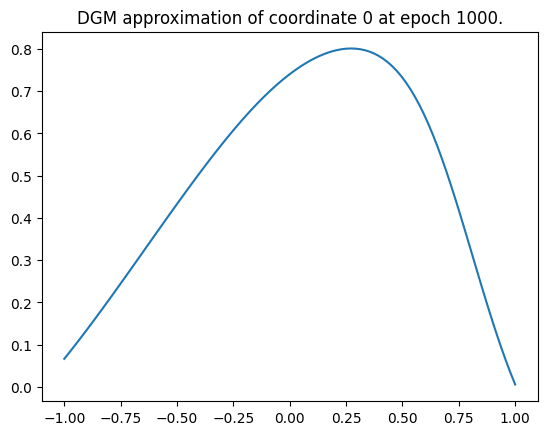

Epoch 1000 with loss 0.21785181760787964


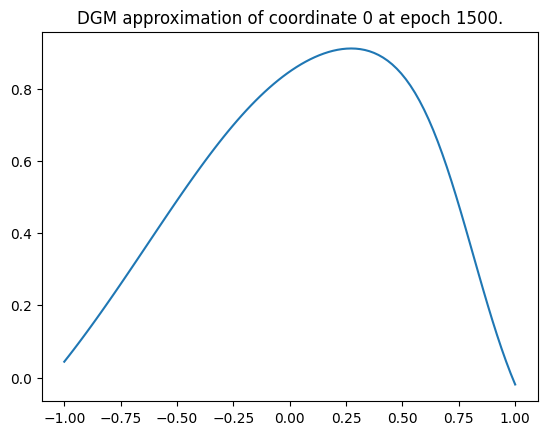

Epoch 1500 with loss 0.2082817554473877


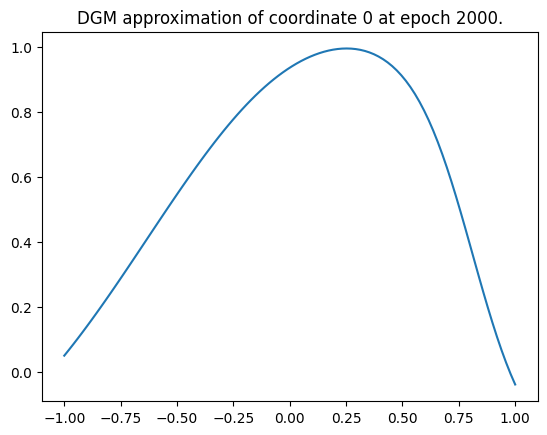

Epoch 2000 with loss 0.1911422312259674


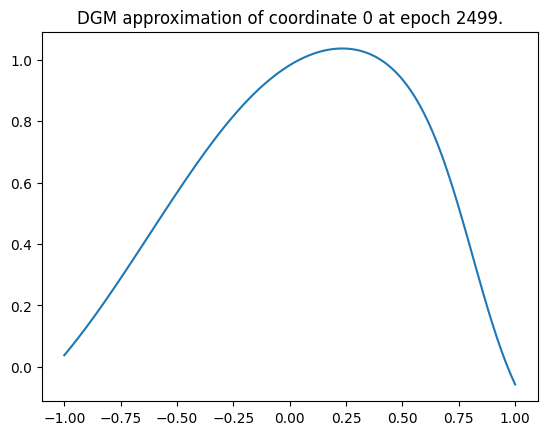

Epoch 2499 with loss 0.1808575987815857
Training of neural network with 2500 epochs take 224.06401181221008 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 224 seconds; L1 error: 5.45E-02; L2 error: 4.38E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


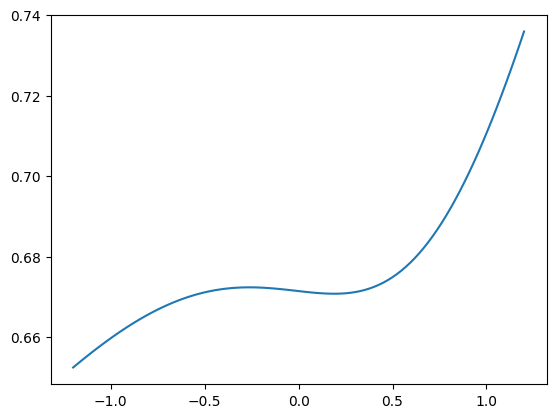

Epoch 0 with loss 1.4857532978057861


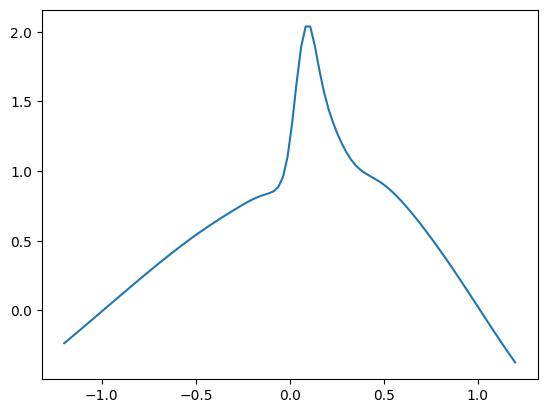

Epoch 500 with loss 0.0008370543946512043


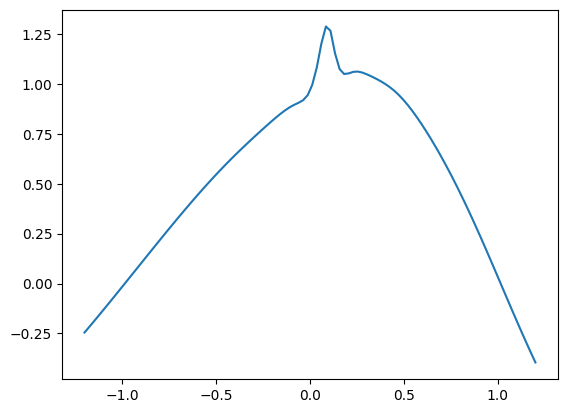

Epoch 1000 with loss 0.002267926698550582


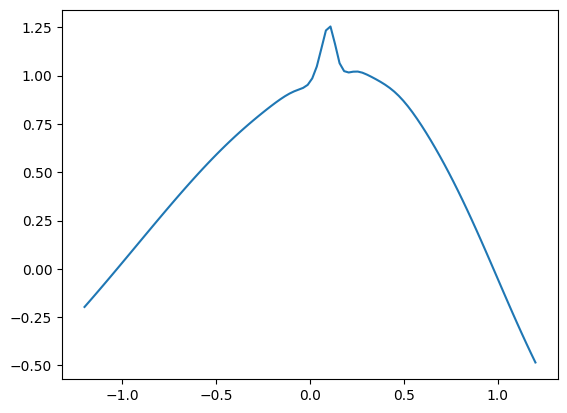

Epoch 1500 with loss 0.0006157648749649525


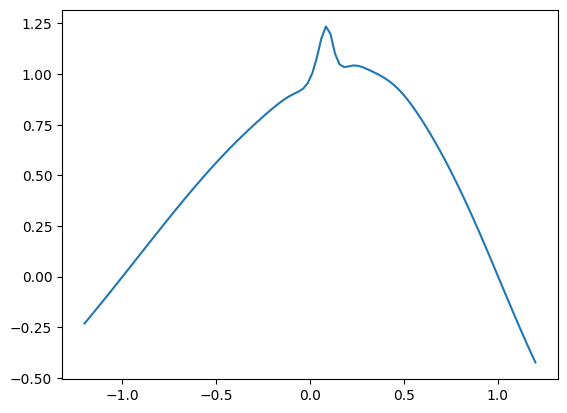

Epoch 2000 with loss 0.0007720041903667152


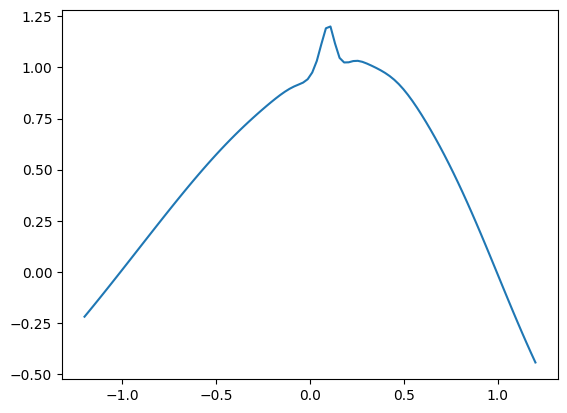

Epoch 2499 with loss 0.0006161112105473876
Training of neural network with 2500 epochs take 140.94456005096436 seconds.
Time taken: 141 seconds; L1 error: 4.39E-02; L2 error: 4.20E-03; rel error: INF.




######## Summary for deep branching method
runtime:        48
fdb runtime:    5
total runtime:  53
mean L1 error:  2.59E-02
std L1 error:   0.00E+00
mean L2 error:  1.14E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        224
mean L1 error:  5.45E-02
std L1 error:   0.00E+00
mean L2 error:  4.38E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  4.39E-02
std L1 error:   0.00E+00
mean L2 error:  4.20E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


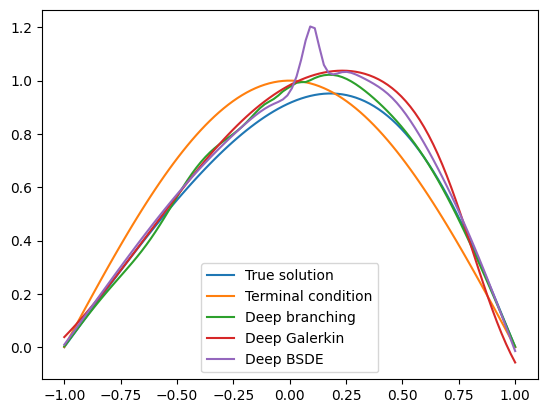

In [8]:
dim = 4
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 5

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 52.19320297241211 seconds.
Patch  0: epoch    0 with loss 2.51E+00


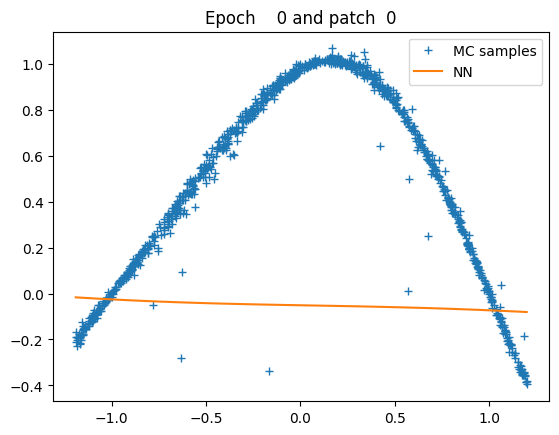

Patch  0: epoch  500 with loss 3.26E-03


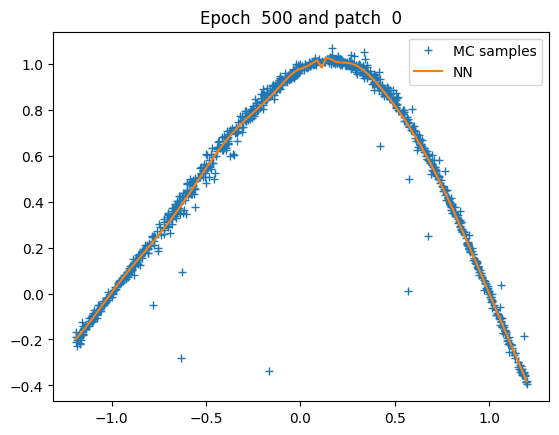

Patch  0: epoch 1000 with loss 3.26E-03


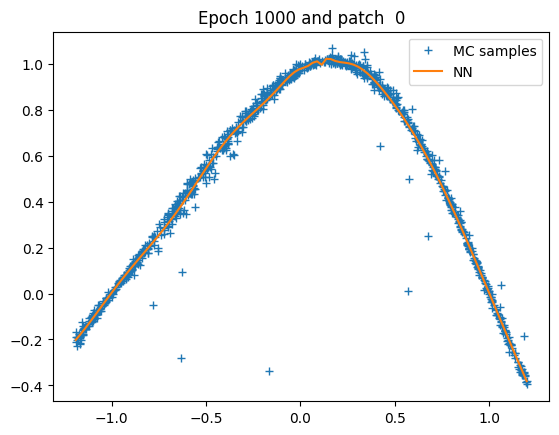

Patch  0: epoch 1500 with loss 3.26E-03


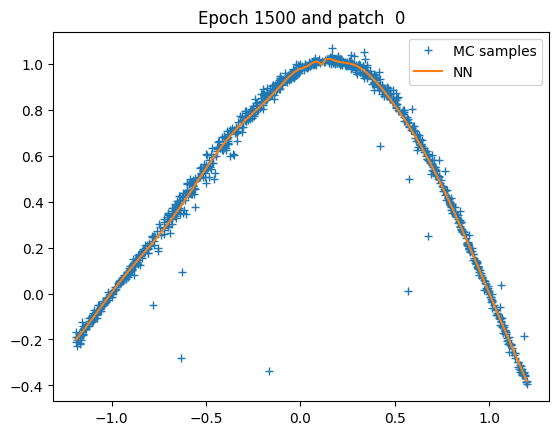

Patch  0: epoch 2000 with loss 3.26E-03


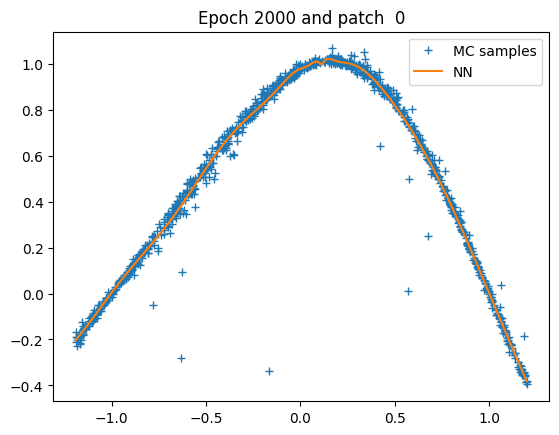

Patch  0: epoch 2499 with loss 3.26E-03


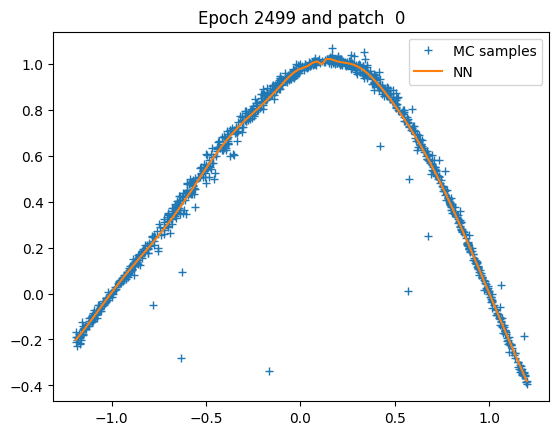

Patch 0: training of u with 2500 epochs take 17.427545070648193 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 53 seconds; L1 error: 2.59E-02; L2 error: 1.09E-03; rel error: INF.
fdb runtime: 17 seconds; total runtime: 70 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


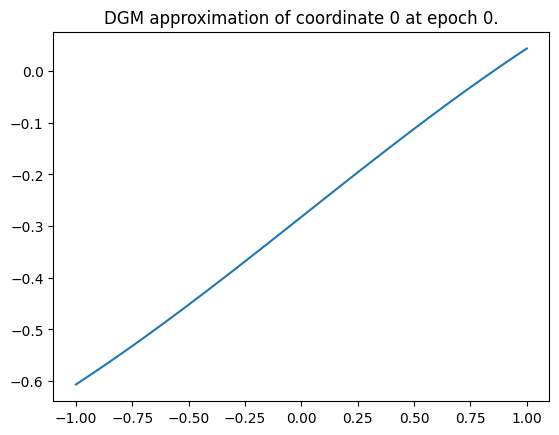

Epoch 0 with loss 2.000722646713257


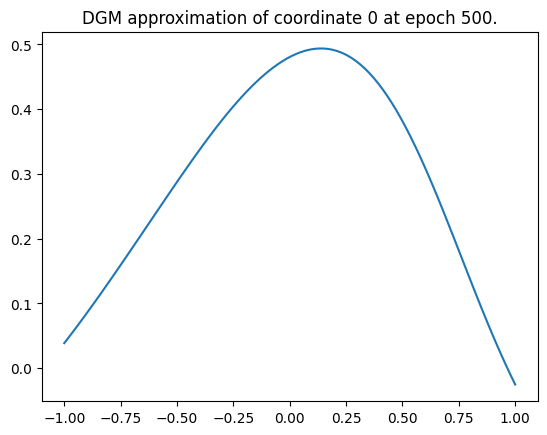

Epoch 500 with loss 0.27136510610580444


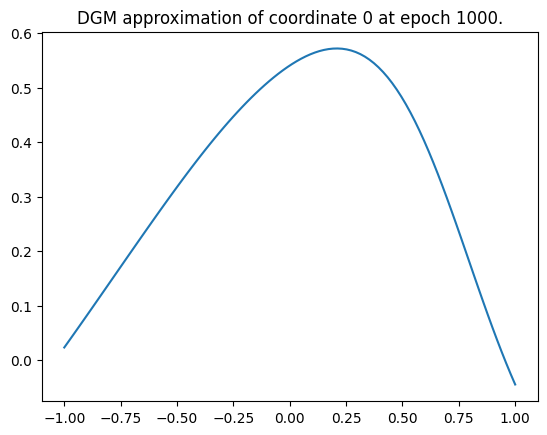

Epoch 1000 with loss 0.24636825919151306


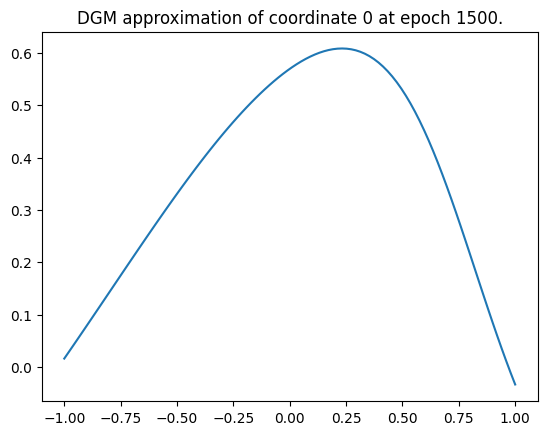

Epoch 1500 with loss 0.24260534346103668


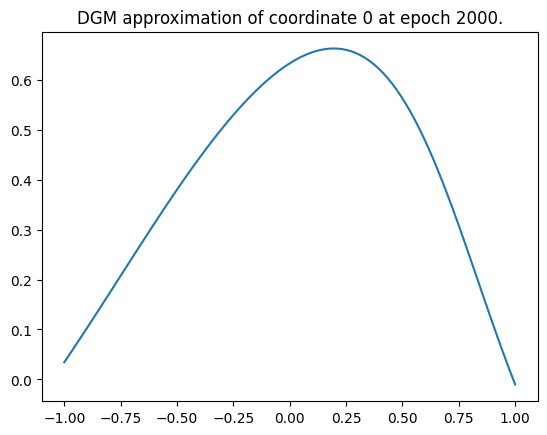

Epoch 2000 with loss 0.24701297283172607


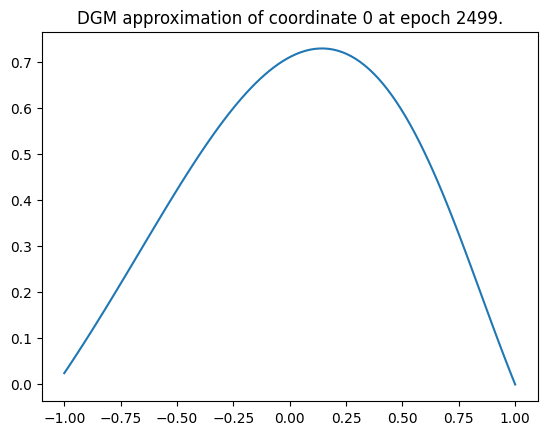

Epoch 2499 with loss 0.2269483208656311
Training of neural network with 2500 epochs take 270.24576926231384 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 270 seconds; L1 error: 1.50E-01; L2 error: 2.73E-02; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


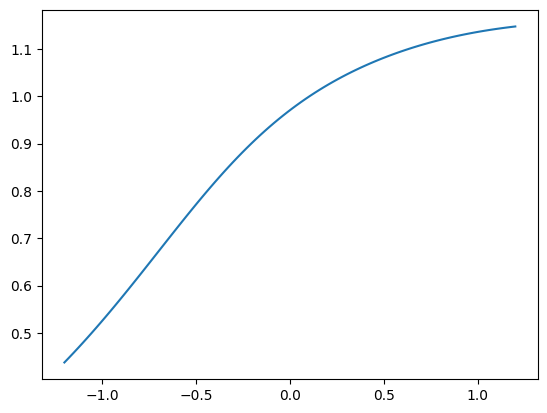

Epoch 0 with loss 1.3198378086090088


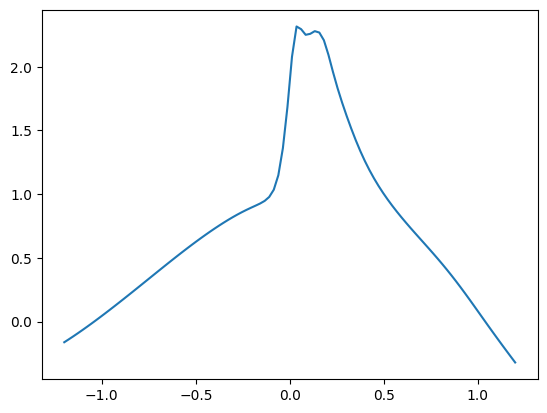

Epoch 500 with loss 0.007174195721745491


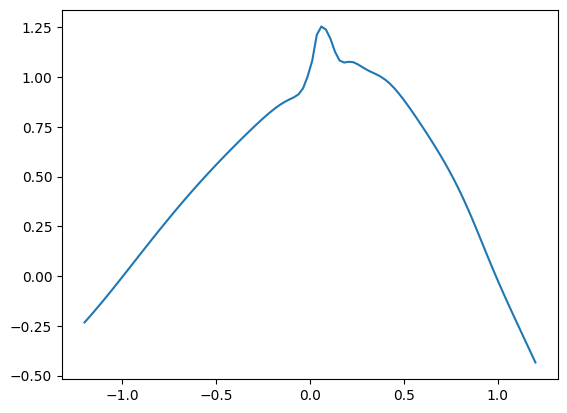

Epoch 1000 with loss 0.000664737424813211


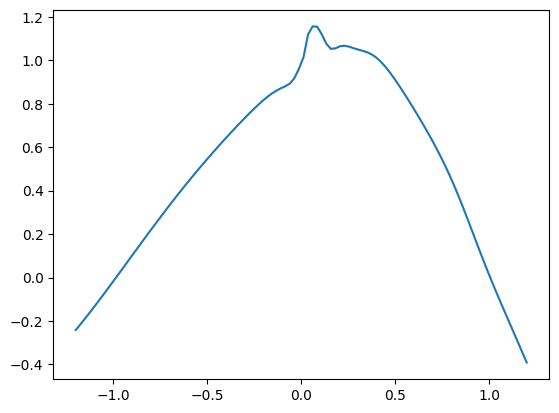

Epoch 1500 with loss 0.002515829633921385


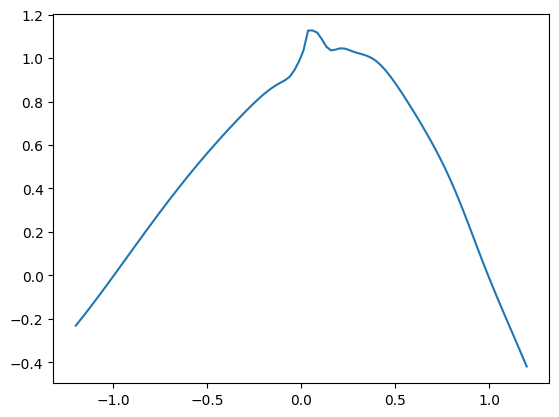

Epoch 2000 with loss 0.0004221791459713131


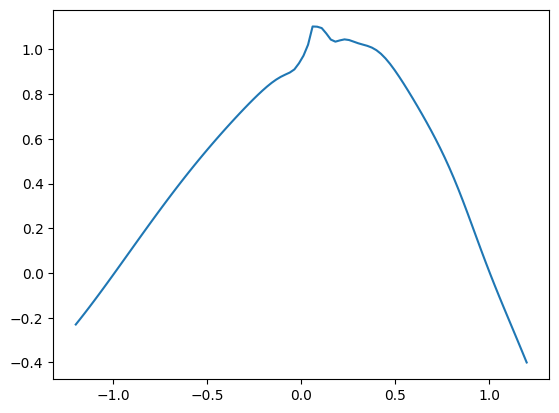

Epoch 2499 with loss 0.0010989432921633124
Training of neural network with 2500 epochs take 138.6874144077301 seconds.
Time taken: 139 seconds; L1 error: 4.11E-02; L2 error: 3.64E-03; rel error: INF.




######## Summary for deep branching method
runtime:        53
fdb runtime:    17
total runtime:  70
mean L1 error:  2.59E-02
std L1 error:   0.00E+00
mean L2 error:  1.09E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        270
mean L1 error:  1.50E-01
std L1 error:   0.00E+00
mean L2 error:  2.73E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        139
mean L1 error:  4.11E-02
std L1 error:   0.00E+00
mean L2 error:  3.64E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


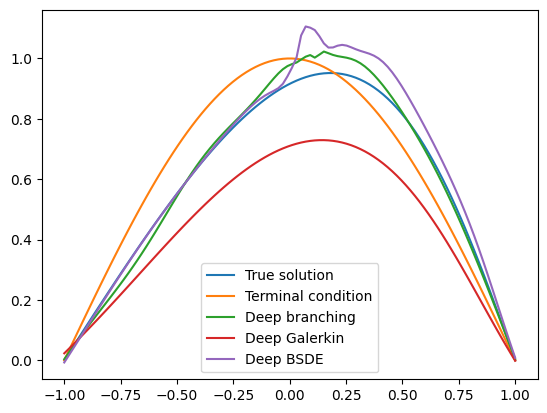

In [9]:
dim = 5
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 6

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 243.17445039749146 seconds.
Patch  0: epoch    0 with loss 4.38E+00


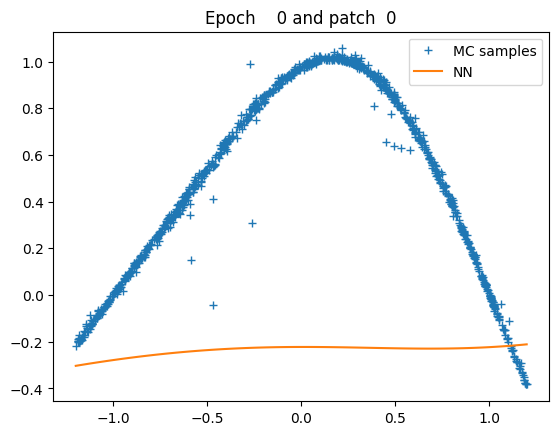

Patch  0: epoch  500 with loss 1.07E-03


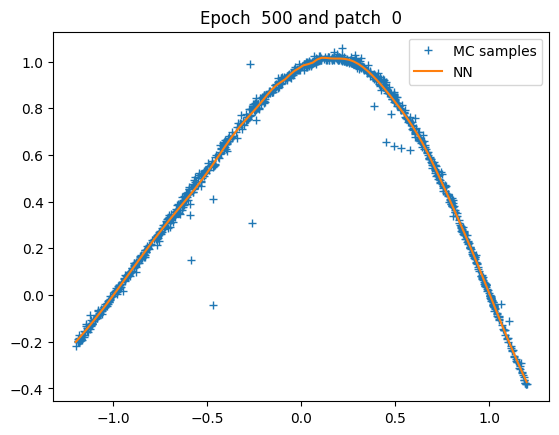

Patch  0: epoch 1000 with loss 1.06E-03


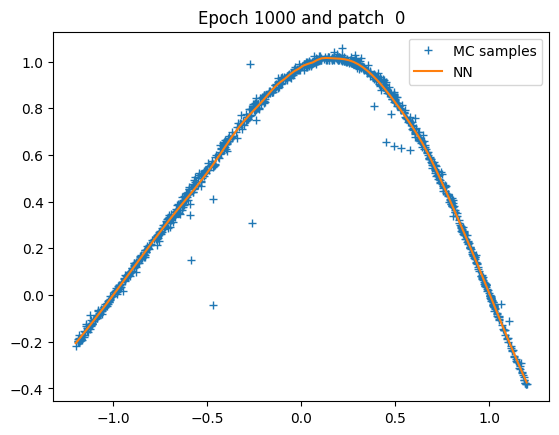

Patch  0: epoch 1500 with loss 1.06E-03


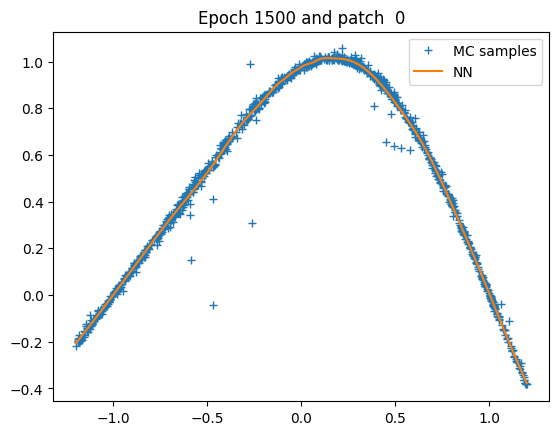

Patch  0: epoch 2000 with loss 1.06E-03


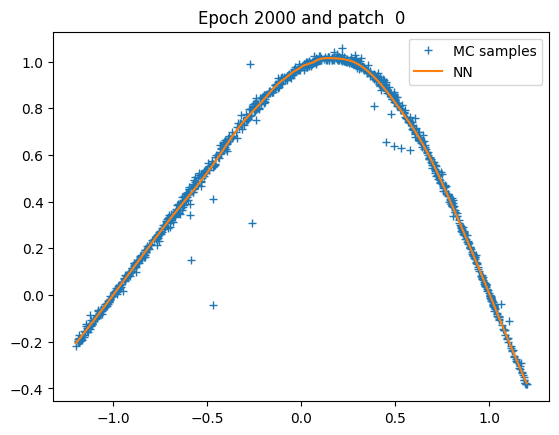

Patch  0: epoch 2499 with loss 1.06E-03


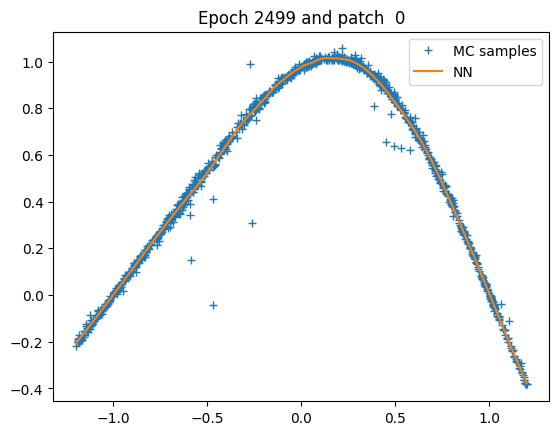

Patch 0: training of u with 2500 epochs take 16.74996328353882 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 203 seconds; L1 error: 2.50E-02; L2 error: 1.08E-03; rel error: INF.
fdb runtime: 58 seconds; total runtime: 261 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


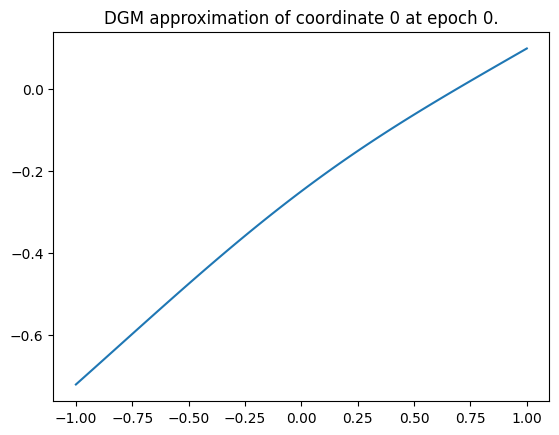

Epoch 0 with loss 1.576241374015808


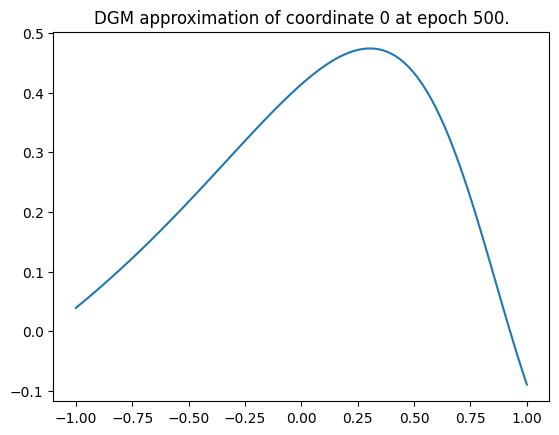

Epoch 500 with loss 0.30408114194869995


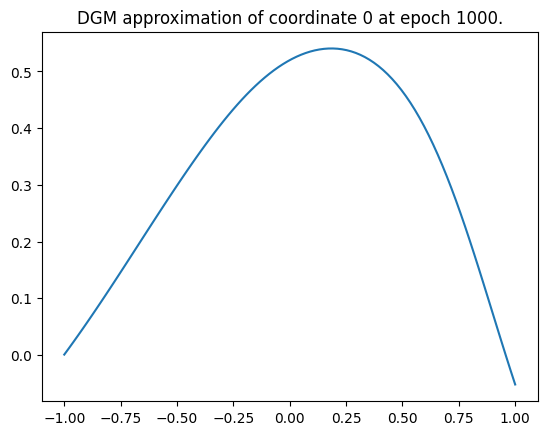

Epoch 1000 with loss 0.2636661231517792


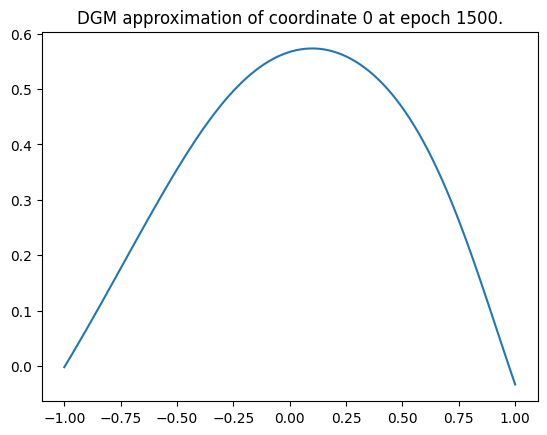

Epoch 1500 with loss 0.25207507610321045


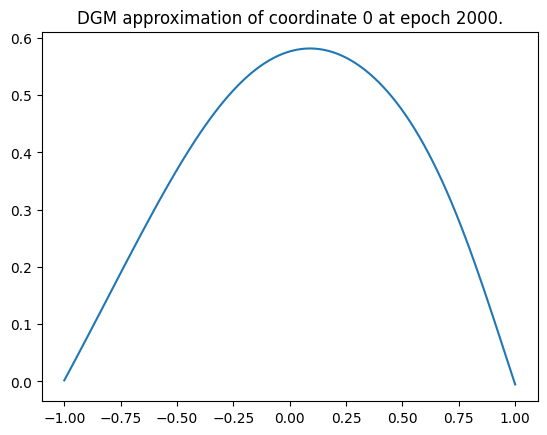

Epoch 2000 with loss 0.24905668199062347


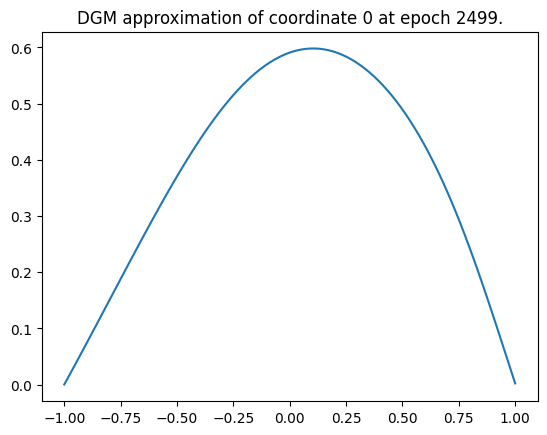

Epoch 2499 with loss 0.23083826899528503
Training of neural network with 2500 epochs take 312.85069465637207 seconds.


Time taken: 313 seconds; L1 error: 2.19E-01; L2 error: 6.04E-02; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


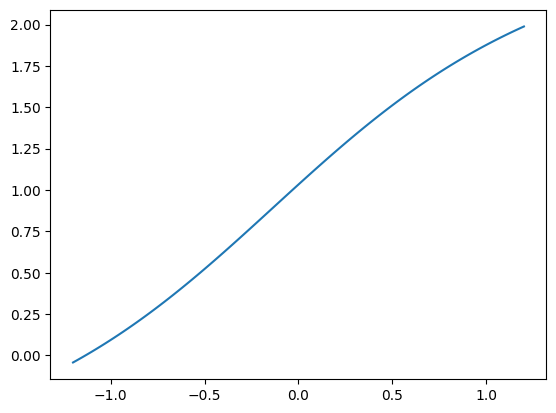

Epoch 0 with loss 1.1166167259216309


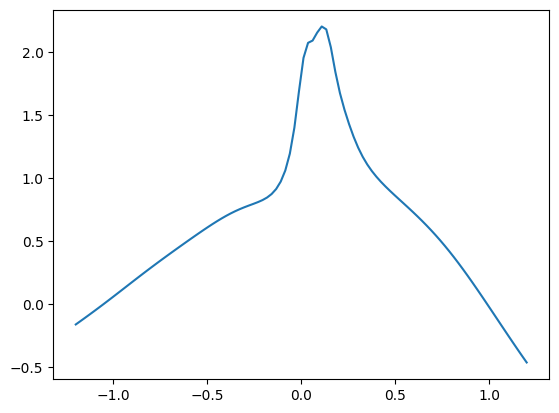

Epoch 500 with loss 0.0019466322846710682


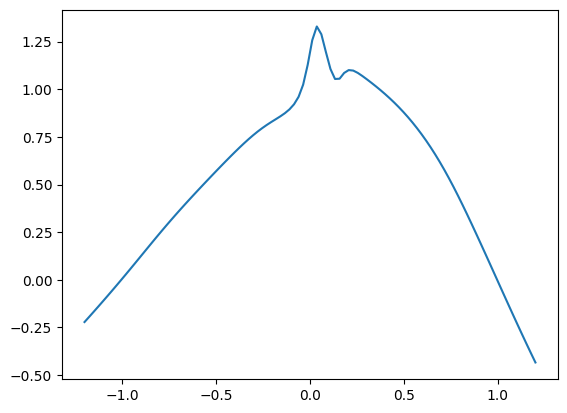

Epoch 1000 with loss 0.0005419390508905053


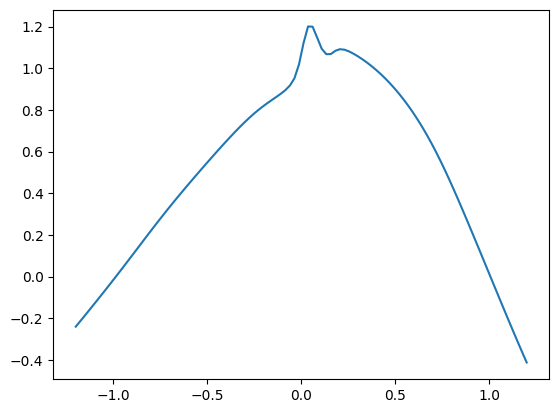

Epoch 1500 with loss 0.0007248779875226319


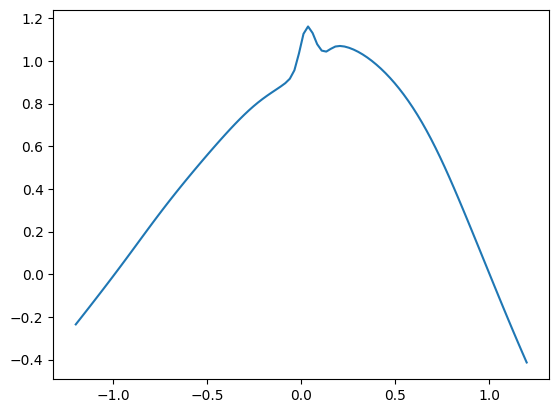

Epoch 2000 with loss 0.00036667301901616156


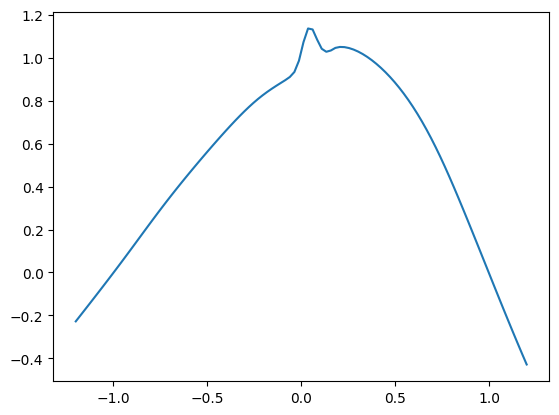

Epoch 2499 with loss 0.0013609263114631176
Training of neural network with 2500 epochs take 138.98085951805115 seconds.
Time taken: 139 seconds; L1 error: 4.06E-02; L2 error: 3.61E-03; rel error: INF.




######## Summary for deep branching method
runtime:        203
fdb runtime:    58
total runtime:  261
mean L1 error:  2.50E-02
std L1 error:   0.00E+00
mean L2 error:  1.08E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        313
mean L1 error:  2.19E-01
std L1 error:   0.00E+00
mean L2 error:  6.04E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        139
mean L1 error:  4.06E-02
std L1 error:   0.00E+00
mean L2 error:  3.61E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


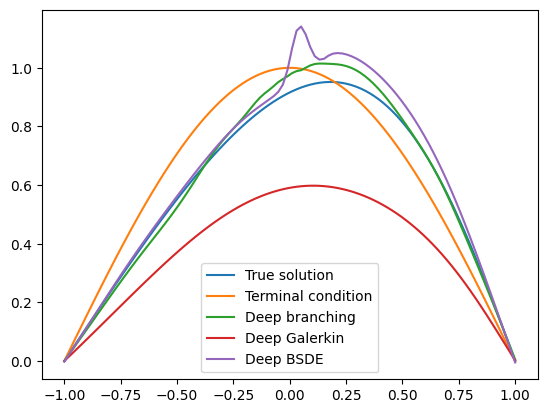

In [10]:
dim = 6
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 7

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 139.82472920417786 seconds.
Patch  0: epoch    0 with loss 5.45E-01


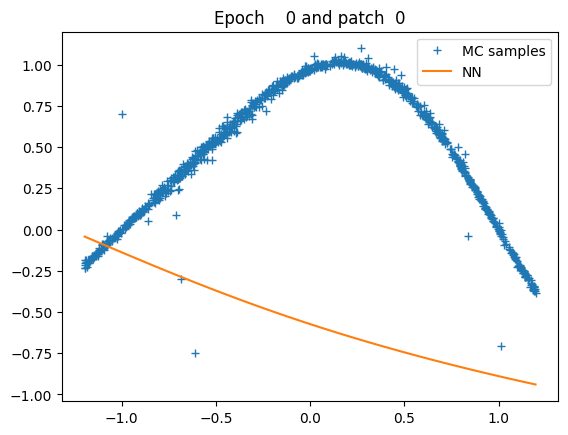

Patch  0: epoch  500 with loss 3.22E-03


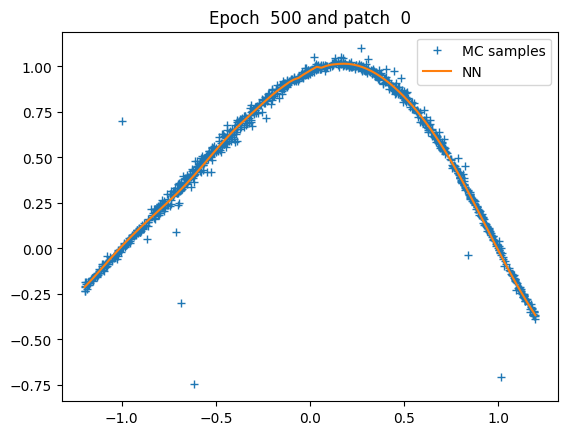

Patch  0: epoch 1000 with loss 3.22E-03


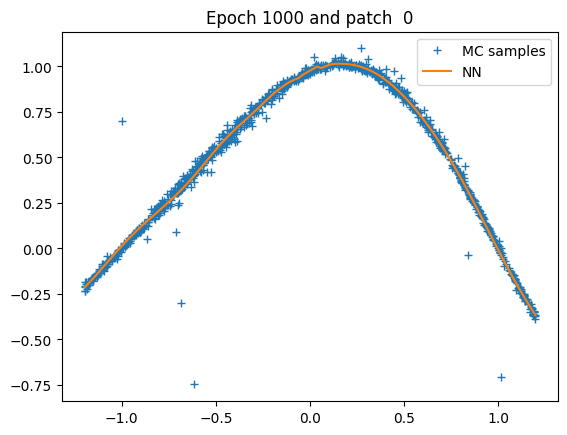

Patch  0: epoch 1500 with loss 3.22E-03


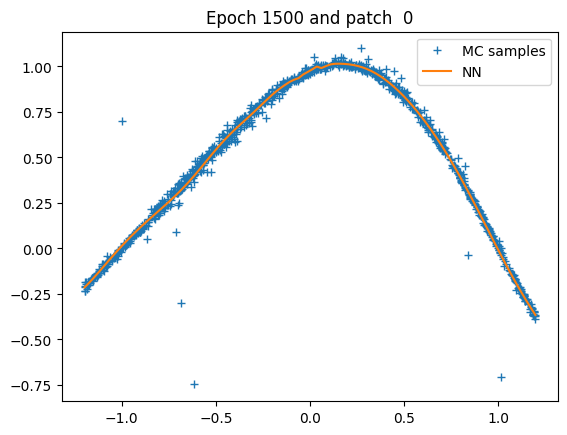

Patch  0: epoch 2000 with loss 3.22E-03


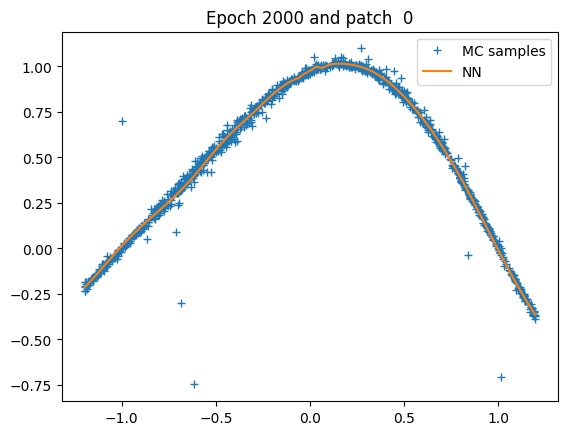

Patch  0: epoch 2499 with loss 3.22E-03


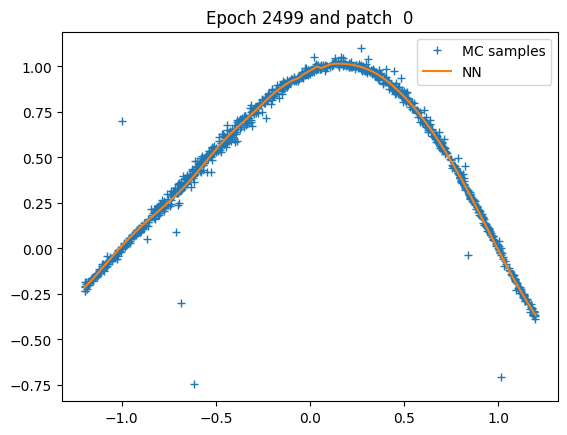

Patch 0: training of u with 2500 epochs take 17.066240787506104 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 83 seconds; L1 error: 2.71E-02; L2 error: 1.15E-03; rel error: INF.
fdb runtime: 76 seconds; total runtime: 158 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


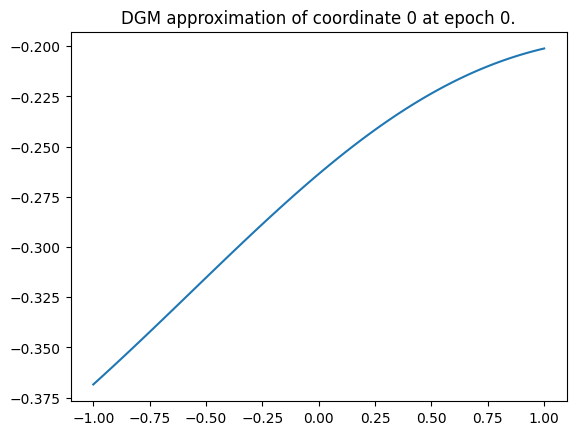

Epoch 0 with loss 1.173201322555542


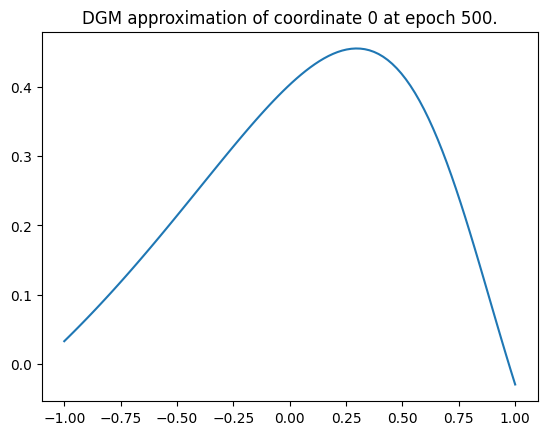

Epoch 500 with loss 0.3233429789543152


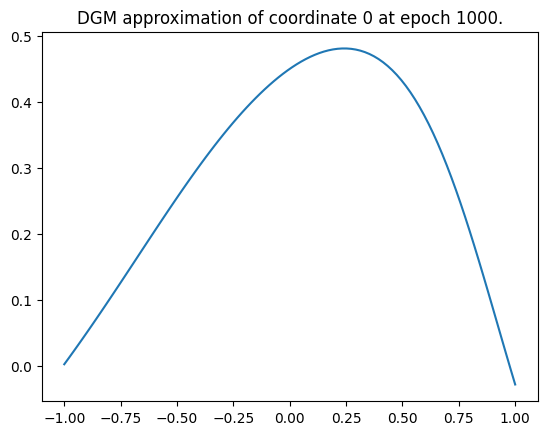

Epoch 1000 with loss 0.27430015802383423


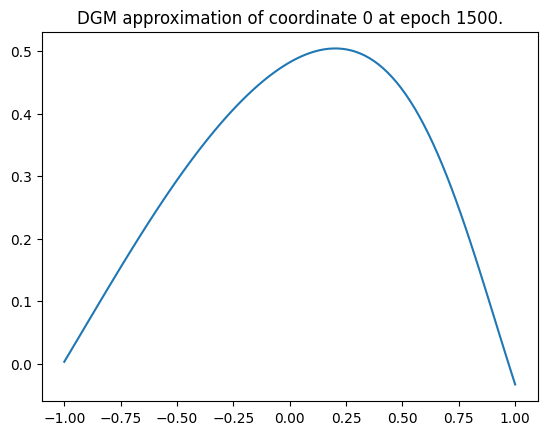

Epoch 1500 with loss 0.2599036991596222


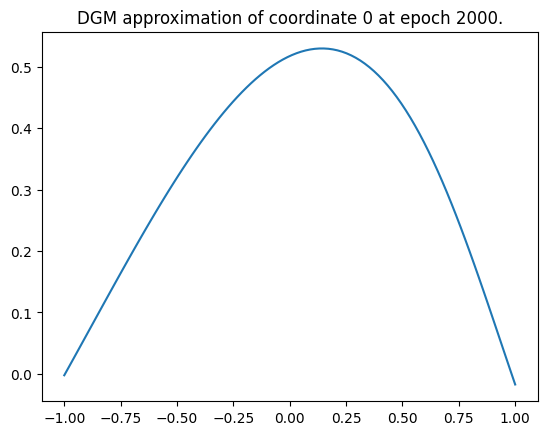

Epoch 2000 with loss 0.25285762548446655


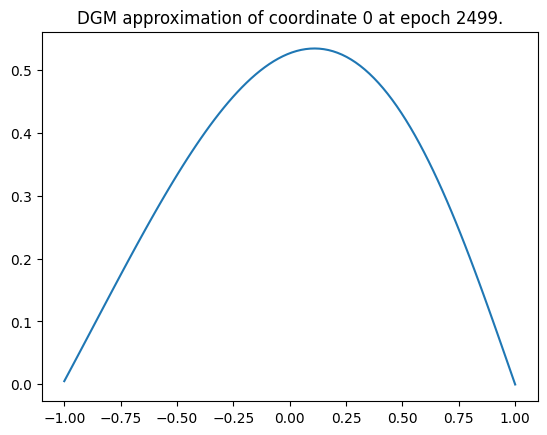

Epoch 2499 with loss 0.24857154488563538
Training of neural network with 2500 epochs take 351.7236559391022 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 352 seconds; L1 error: 2.62E-01; L2 error: 8.62E-02; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


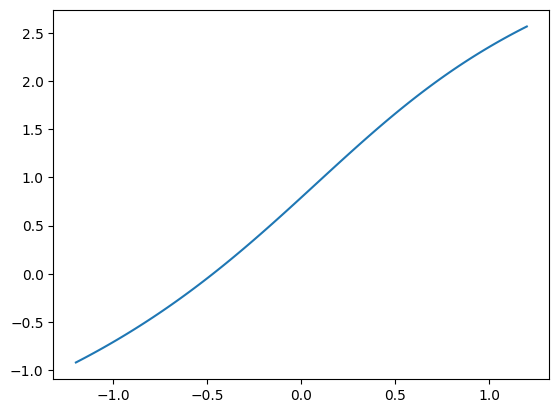

Epoch 0 with loss 0.6358468532562256


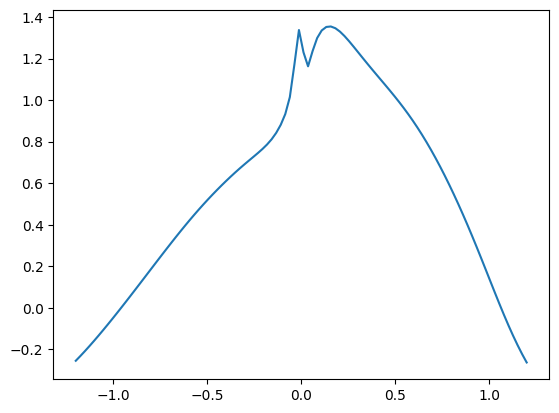

Epoch 500 with loss 0.010610916651785374


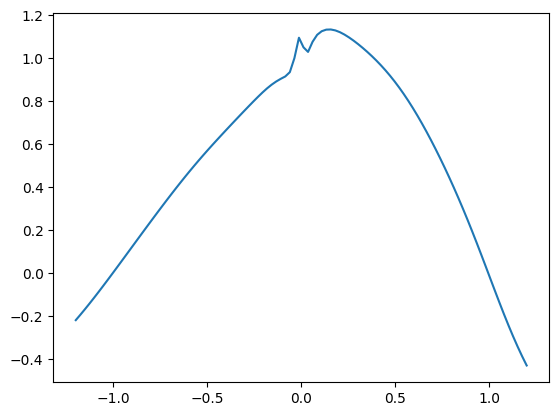

Epoch 1000 with loss 0.001329611288383603


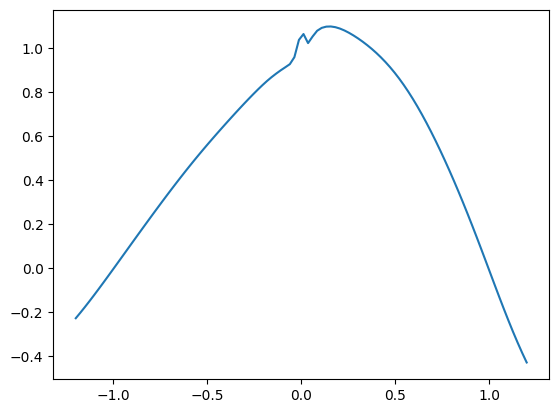

Epoch 1500 with loss 0.00033269901177845895


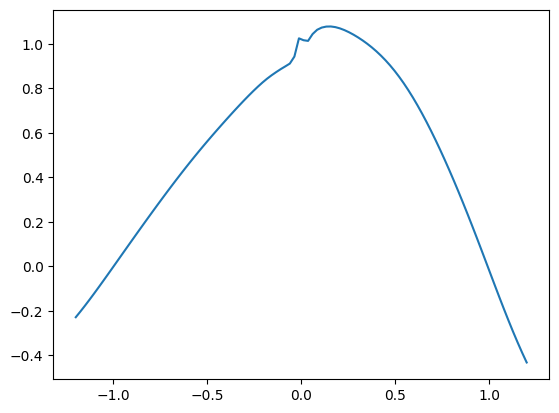

Epoch 2000 with loss 0.0009544137283228338


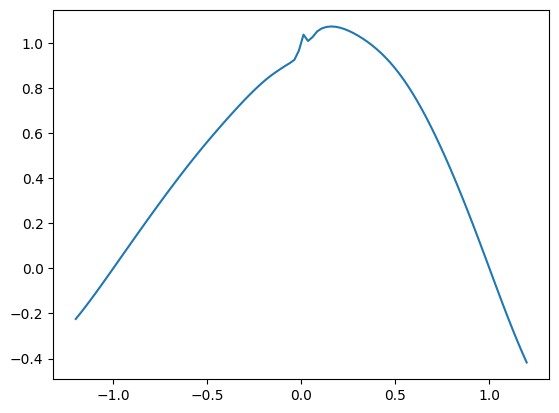

Epoch 2499 with loss 0.00035706820199266076
Training of neural network with 2500 epochs take 139.5480031967163 seconds.
Time taken: 140 seconds; L1 error: 4.11E-02; L2 error: 3.18E-03; rel error: INF.




######## Summary for deep branching method
runtime:        83
fdb runtime:    76
total runtime:  158
mean L1 error:  2.71E-02
std L1 error:   0.00E+00
mean L2 error:  1.15E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        352
mean L1 error:  2.62E-01
std L1 error:   0.00E+00
mean L2 error:  8.62E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        140
mean L1 error:  4.11E-02
std L1 error:   0.00E+00
mean L2 error:  3.18E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


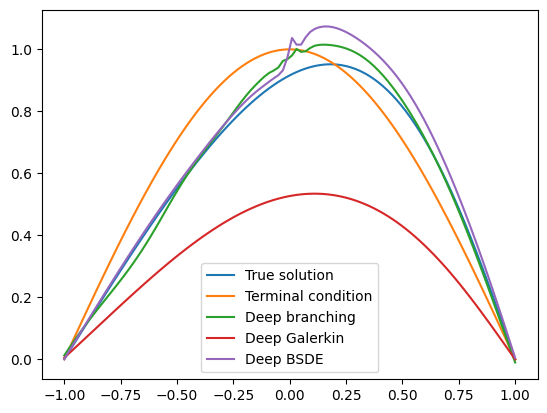

In [12]:
dim = 7
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 8

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 134.03328680992126 seconds.
Patch  0: epoch    0 with loss 2.79E+00


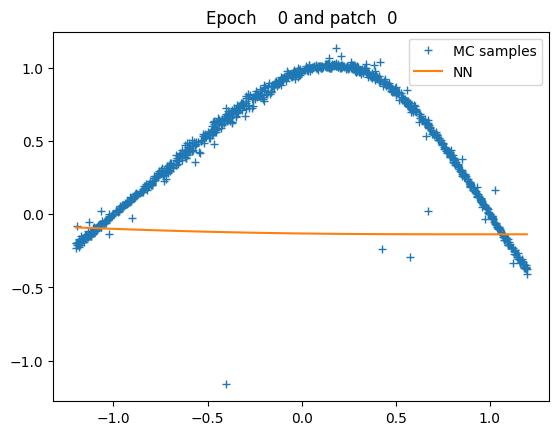

Patch  0: epoch  500 with loss 6.44E-03


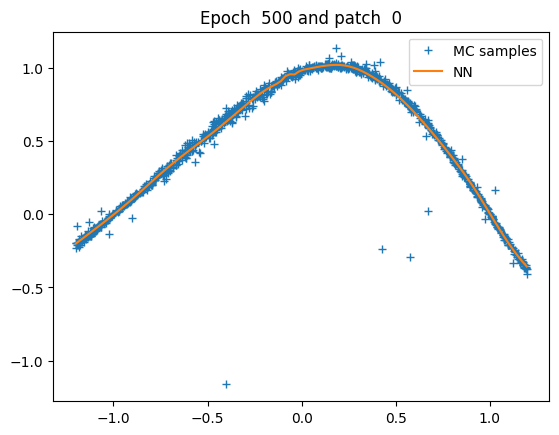

Patch  0: epoch 1000 with loss 6.43E-03


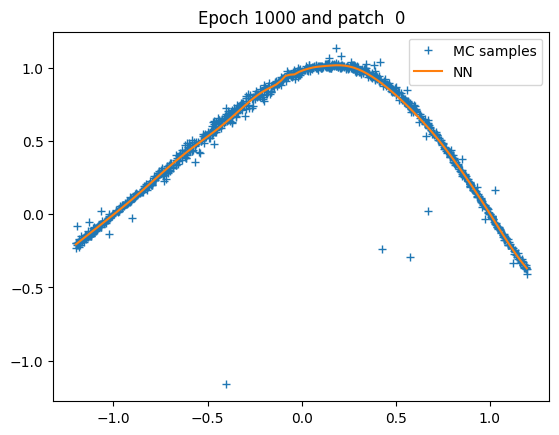

Patch  0: epoch 1500 with loss 6.42E-03


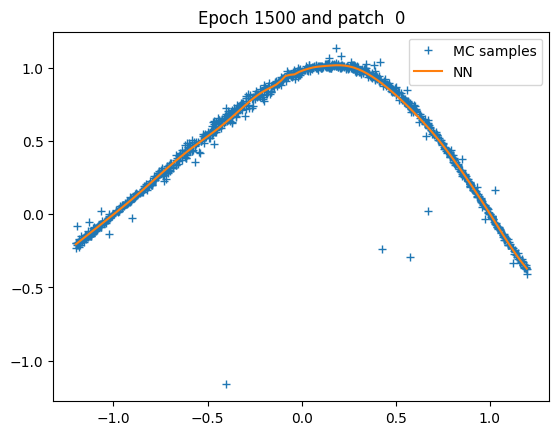

Patch  0: epoch 2000 with loss 6.42E-03


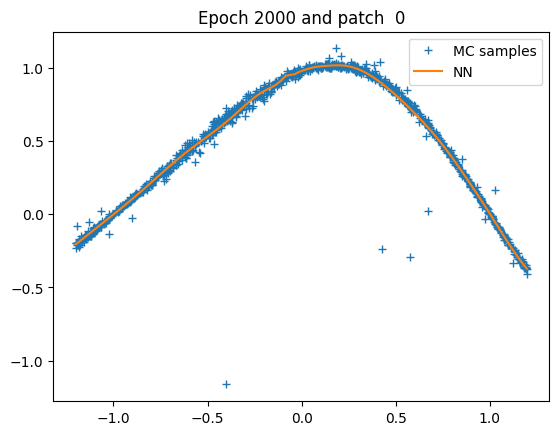

Patch  0: epoch 2499 with loss 6.42E-03


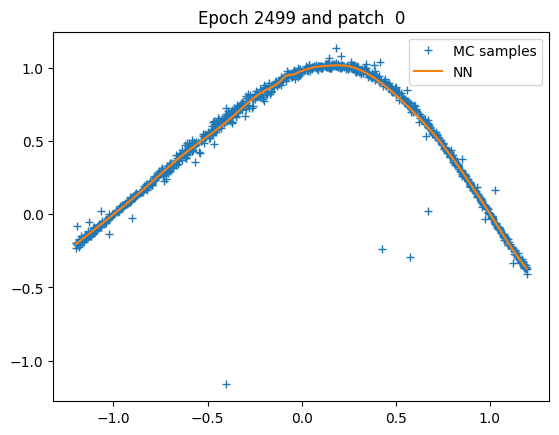

Patch 0: training of u with 2500 epochs take 17.005194187164307 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 93 seconds; L1 error: 2.56E-02; L2 error: 1.08E-03; rel error: INF.
fdb runtime: 60 seconds; total runtime: 153 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


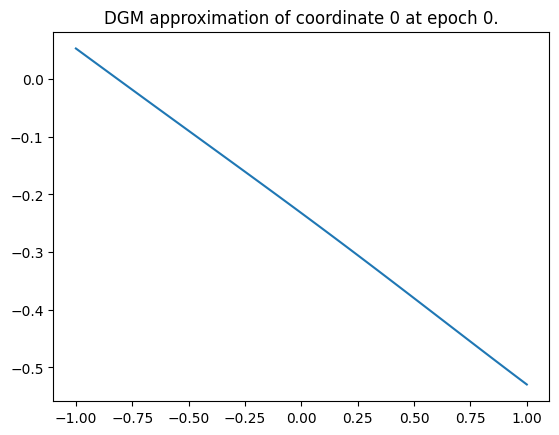

Epoch 0 with loss 1.153261661529541


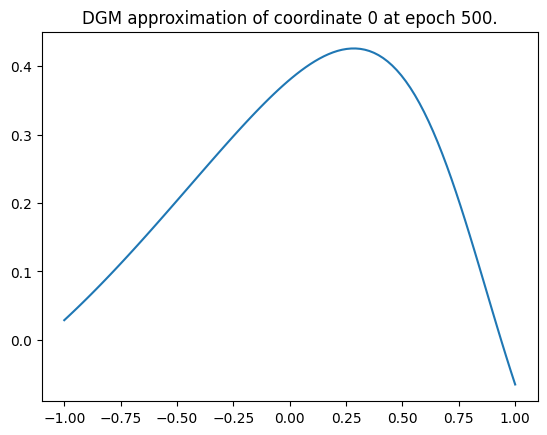

Epoch 500 with loss 0.3240600526332855


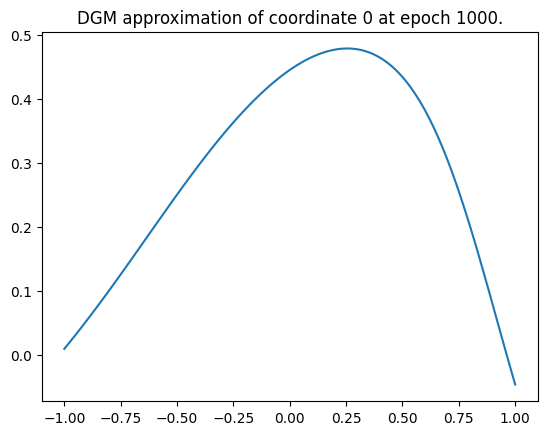

Epoch 1000 with loss 0.29815661907196045


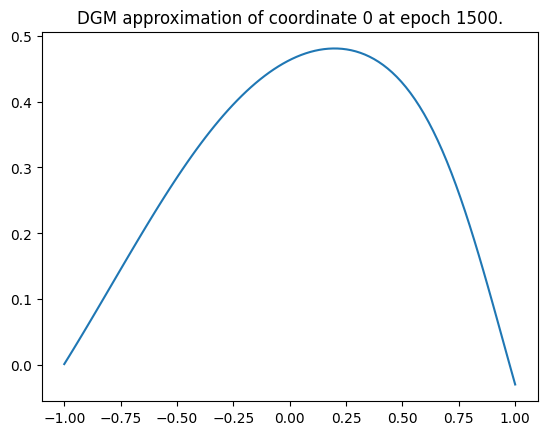

Epoch 1500 with loss 0.27392423152923584


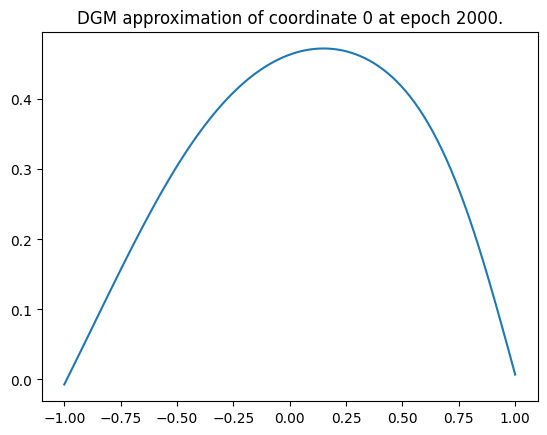

Epoch 2000 with loss 0.2592106759548187


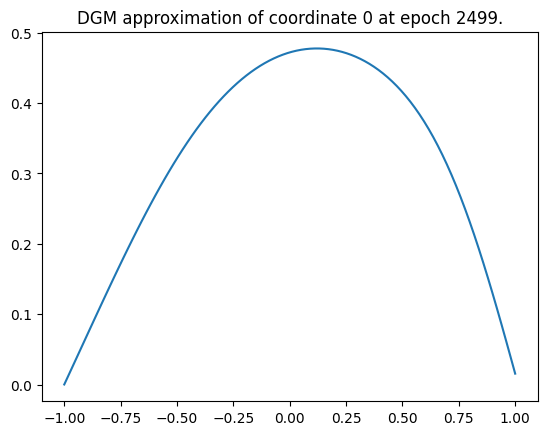

Epoch 2499 with loss 0.25383591651916504
Training of neural network with 2500 epochs take 391.6681716442108 seconds.


Time taken: 392 seconds; L1 error: 2.78E-01; L2 error: 1.01E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


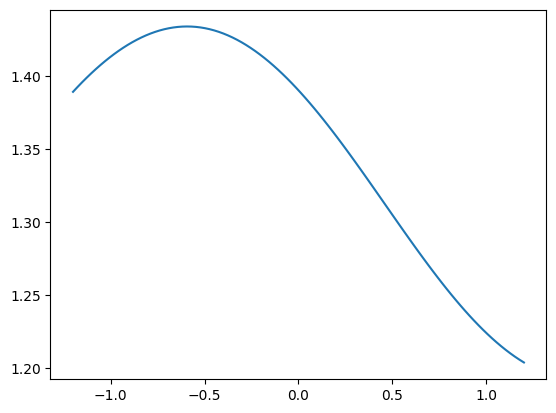

Epoch 0 with loss 1.2951319217681885


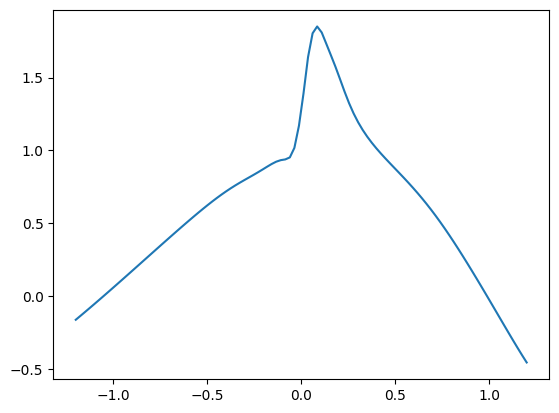

Epoch 500 with loss 0.0016102519584819674


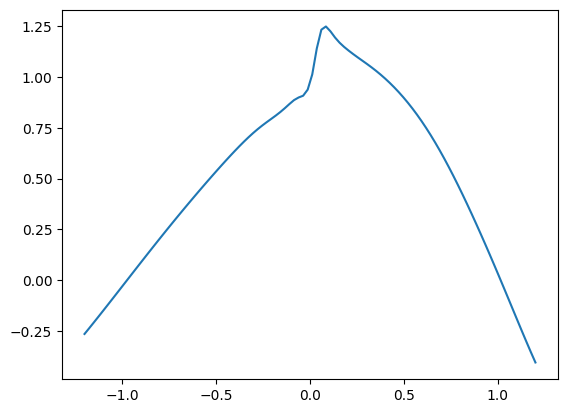

Epoch 1000 with loss 0.0005223457119427621


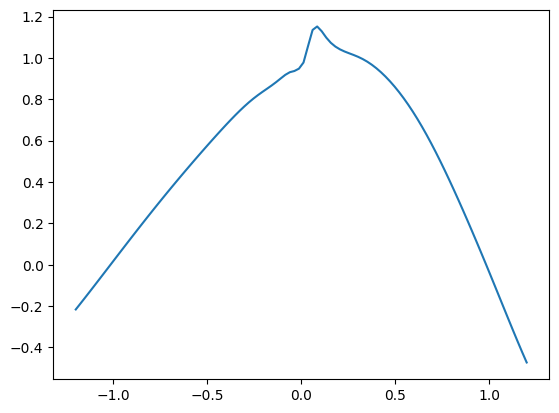

Epoch 1500 with loss 0.0017133543733507395


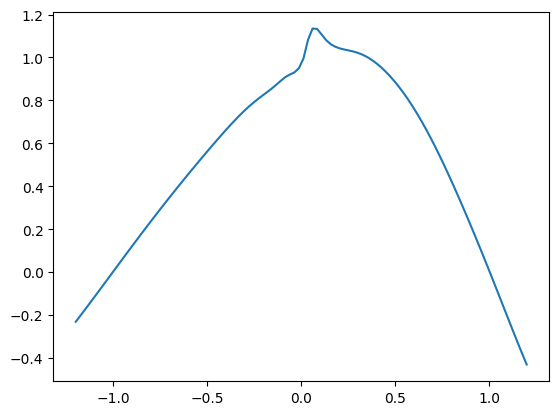

Epoch 2000 with loss 0.0010463738581165671


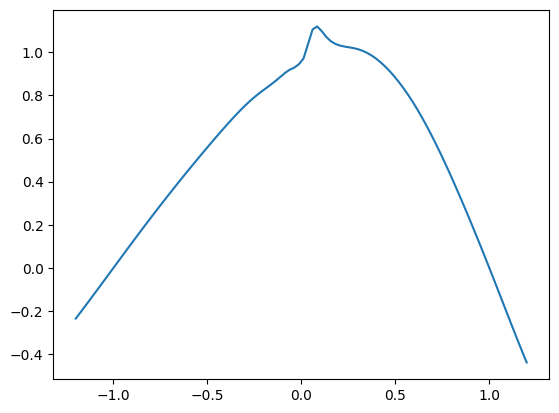

Epoch 2499 with loss 0.001239120145328343
Training of neural network with 2500 epochs take 135.52860045433044 seconds.
Time taken: 136 seconds; L1 error: 3.69E-02; L2 error: 3.00E-03; rel error: INF.




######## Summary for deep branching method
runtime:        93
fdb runtime:    60
total runtime:  153
mean L1 error:  2.56E-02
std L1 error:   0.00E+00
mean L2 error:  1.08E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        392
mean L1 error:  2.78E-01
std L1 error:   0.00E+00
mean L2 error:  1.01E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        136
mean L1 error:  3.69E-02
std L1 error:   0.00E+00
mean L2 error:  3.00E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


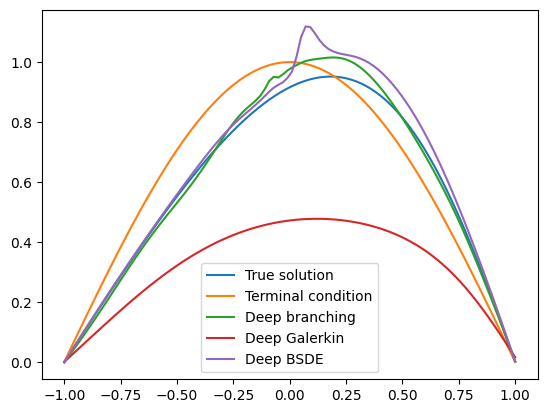

In [13]:
dim = 8
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 9

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 299.05630373954773 seconds.
Patch  0: epoch    0 with loss 1.39E+00


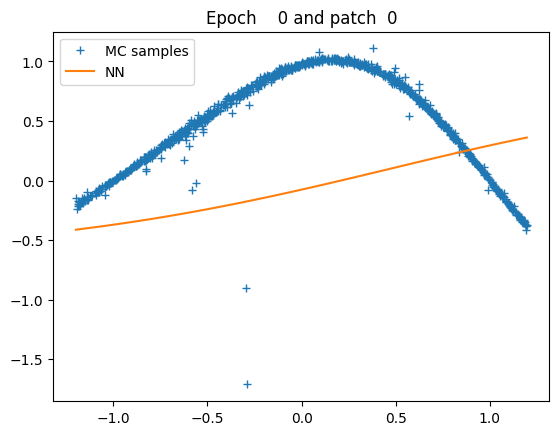

Patch  0: epoch  500 with loss 9.47E-03


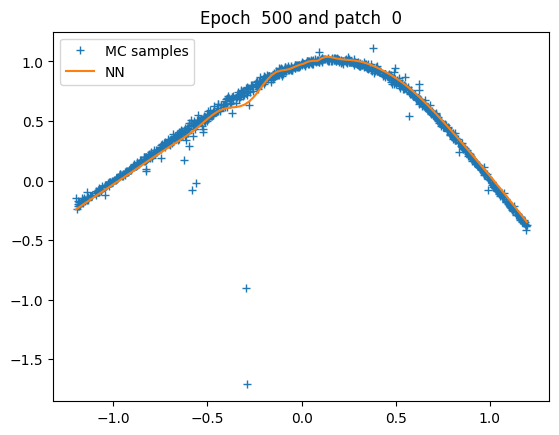

Patch  0: epoch 1000 with loss 9.05E-03


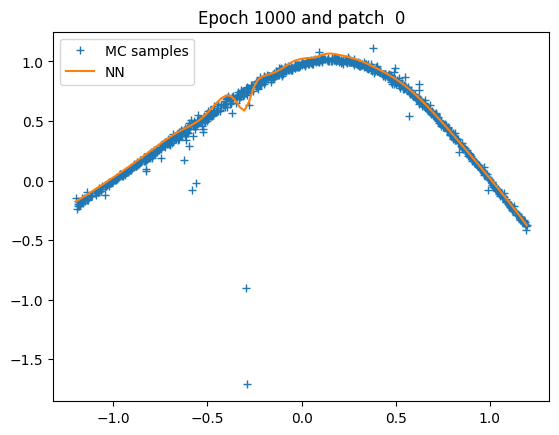

Patch  0: epoch 1500 with loss 8.94E-03


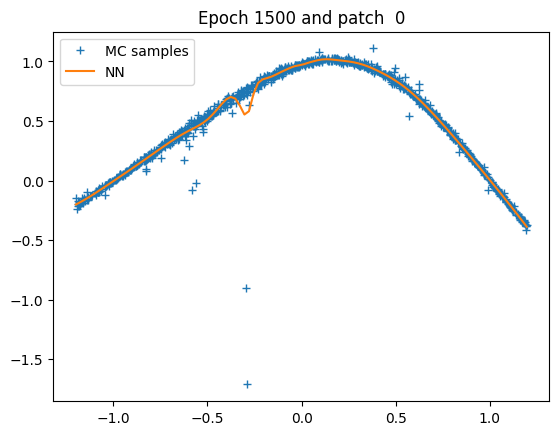

Patch  0: epoch 2000 with loss 8.80E-03


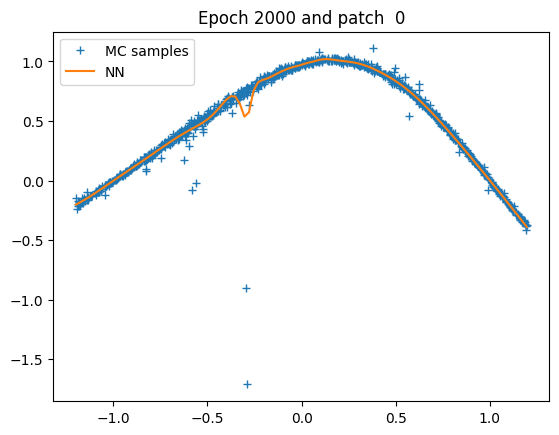

Patch  0: epoch 2499 with loss 8.78E-03


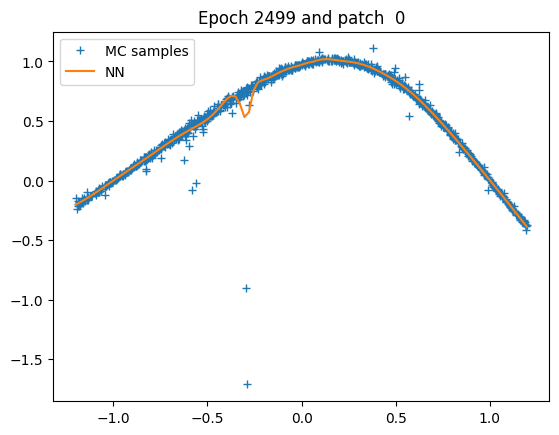

Patch 0: training of u with 2500 epochs take 18.05294108390808 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 118 seconds; L1 error: 3.26E-02; L2 error: 2.05E-03; rel error: INF.
fdb runtime: 203 seconds; total runtime: 320 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


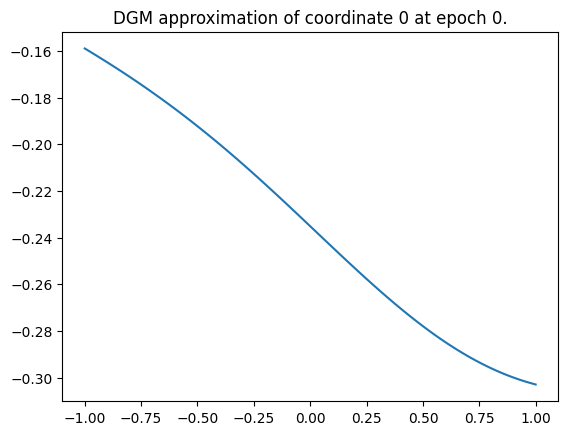

Epoch 0 with loss 0.974217414855957


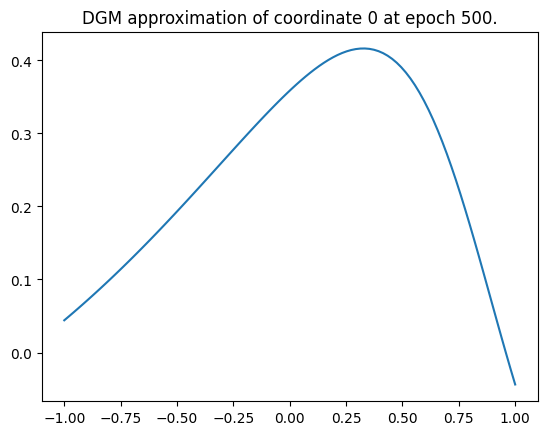

Epoch 500 with loss 0.3446926176548004


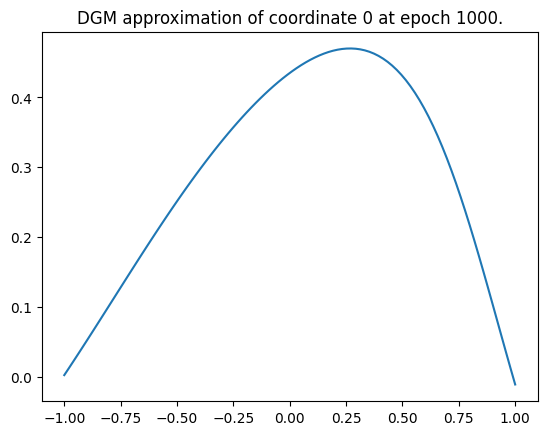

Epoch 1000 with loss 0.282585471868515


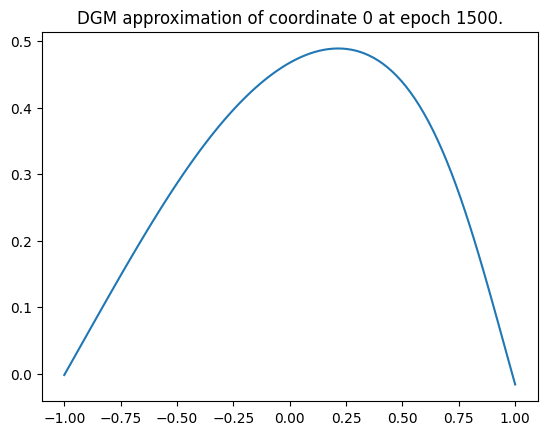

Epoch 1500 with loss 0.26224085688591003


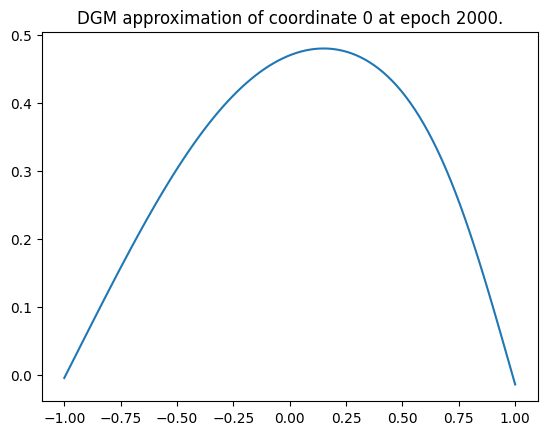

Epoch 2000 with loss 0.2671070694923401


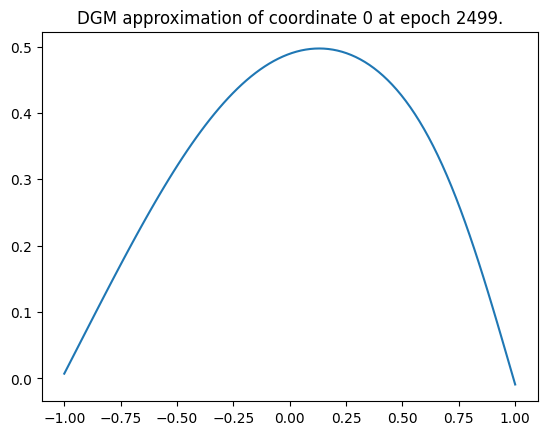

Epoch 2499 with loss 0.25231343507766724
Training of neural network with 2500 epochs take 437.92095971107483 seconds.


Time taken: 438 seconds; L1 error: 2.74E-01; L2 error: 9.61E-02; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


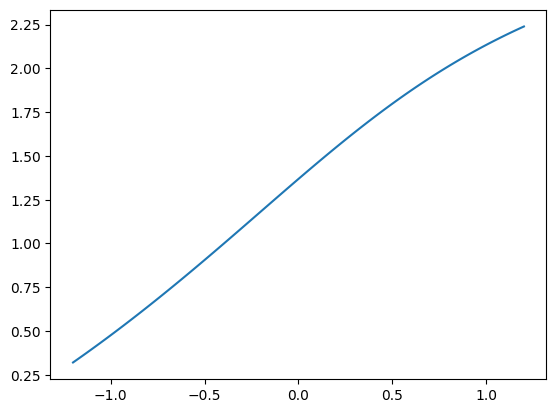

Epoch 0 with loss 1.4980647563934326


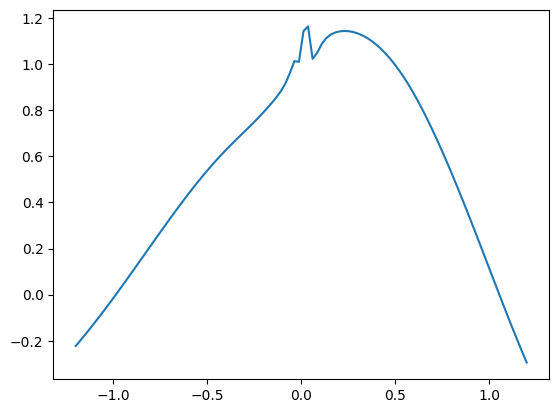

Epoch 500 with loss 0.0071719312109053135


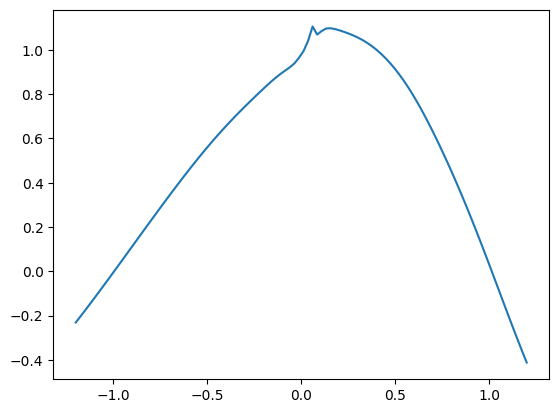

Epoch 1000 with loss 0.0008076661033555865


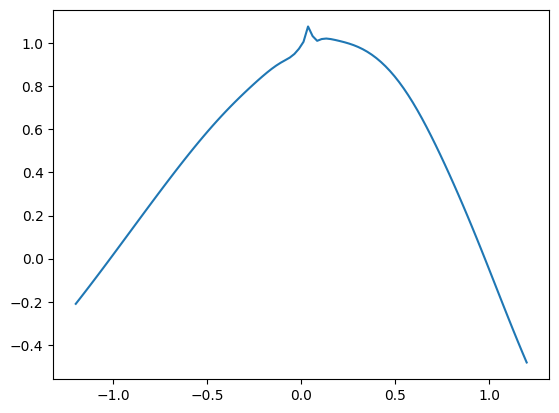

Epoch 1500 with loss 0.0004072899464517832


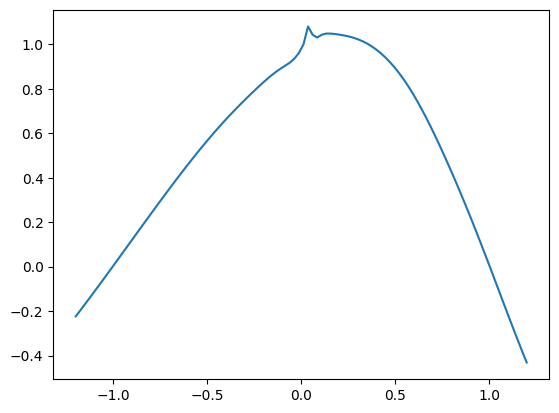

Epoch 2000 with loss 0.0012157548917457461


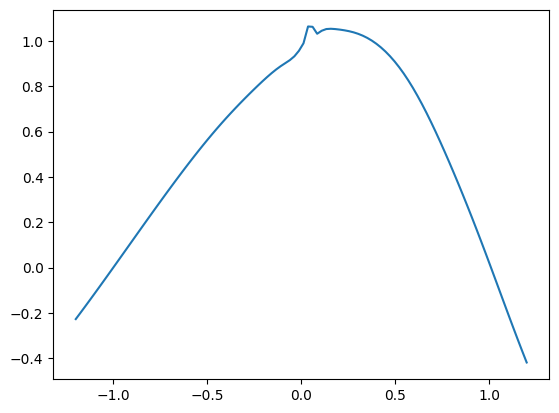

Epoch 2499 with loss 0.0005133579252287745
Training of neural network with 2500 epochs take 140.8167736530304 seconds.
Time taken: 141 seconds; L1 error: 4.37E-02; L2 error: 3.40E-03; rel error: INF.




######## Summary for deep branching method
runtime:        118
fdb runtime:    203
total runtime:  320
mean L1 error:  3.26E-02
std L1 error:   0.00E+00
mean L2 error:  2.05E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        438
mean L1 error:  2.74E-01
std L1 error:   0.00E+00
mean L2 error:  9.61E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        141
mean L1 error:  4.37E-02
std L1 error:   0.00E+00
mean L2 error:  3.40E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


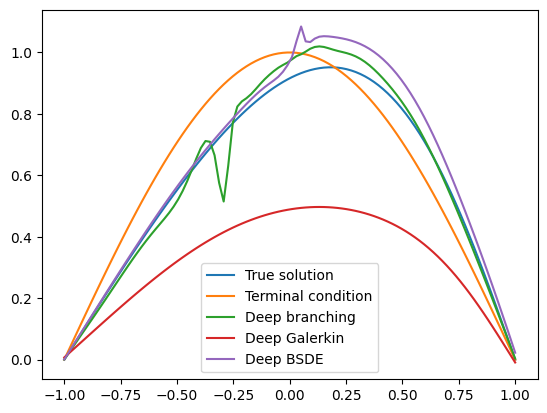

In [14]:
dim = 9
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 10

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 224.9668881893158 seconds.
Patch  0: epoch    0 with loss 9.16E-01


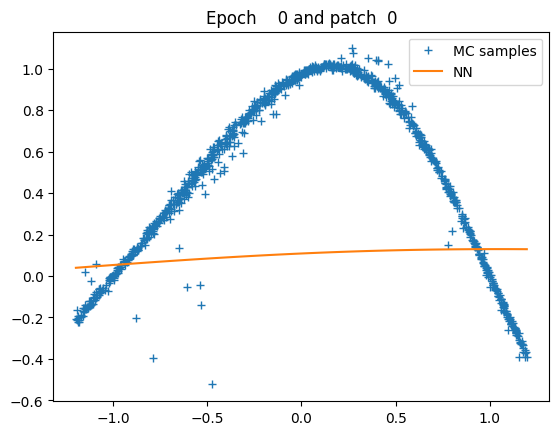

Patch  0: epoch  500 with loss 3.35E-03


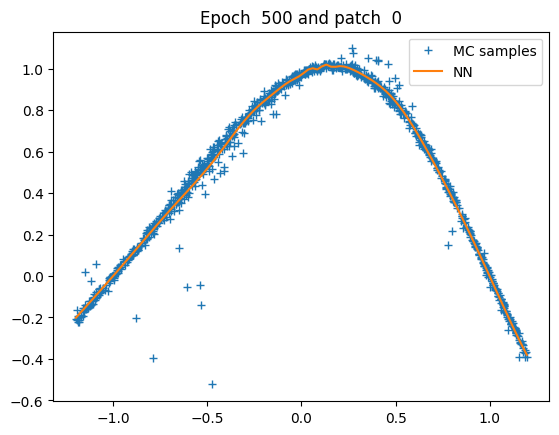

Patch  0: epoch 1000 with loss 3.36E-03


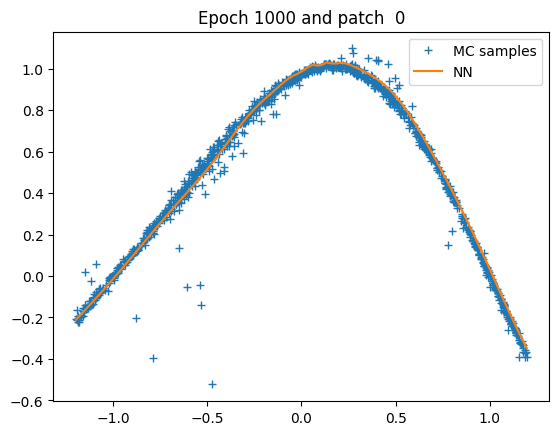

Patch  0: epoch 1500 with loss 3.35E-03


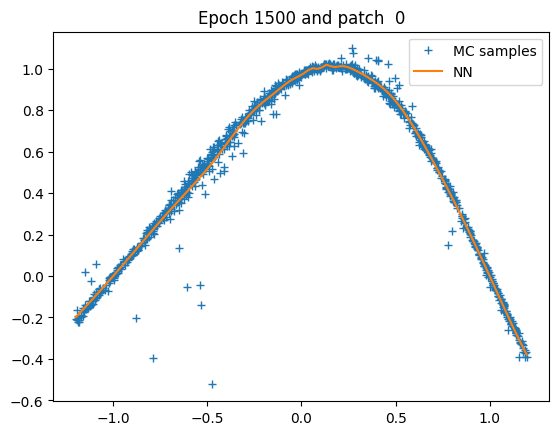

Patch  0: epoch 2000 with loss 3.35E-03


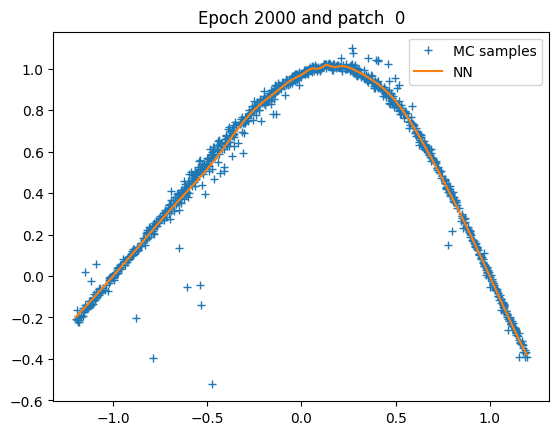

Patch  0: epoch 2499 with loss 3.35E-03


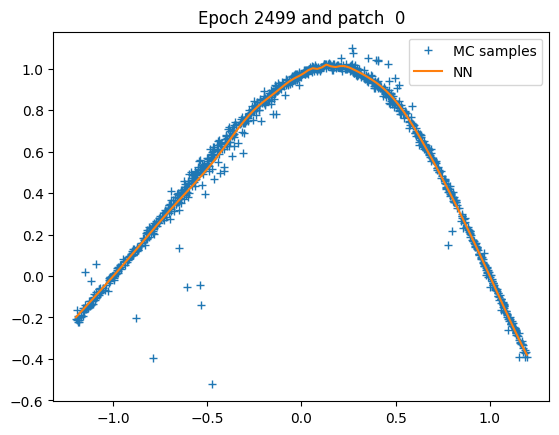

Patch 0: training of u with 2500 epochs take 17.101439476013184 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 105 seconds; L1 error: 2.97E-02; L2 error: 1.24E-03; rel error: INF.
fdb runtime: 142 seconds; total runtime: 247 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


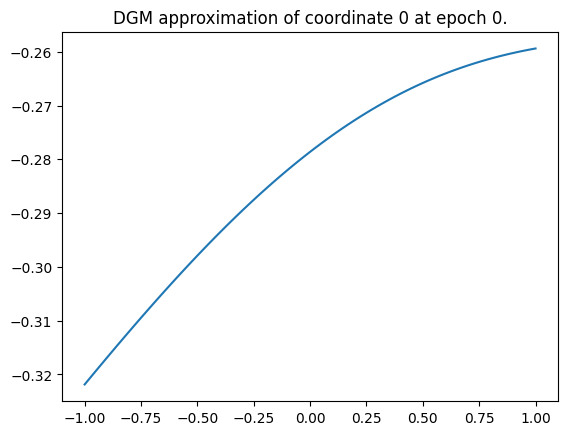

Epoch 0 with loss 1.4069530963897705


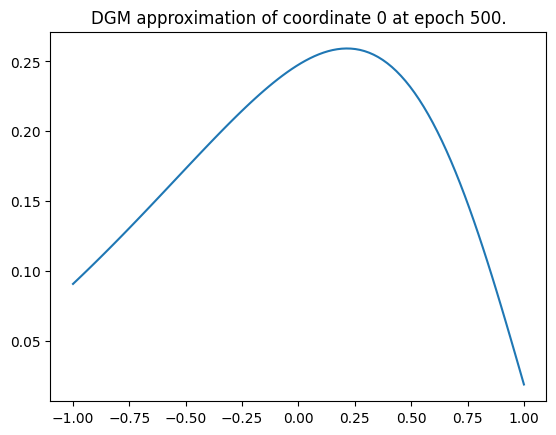

Epoch 500 with loss 0.39276111125946045


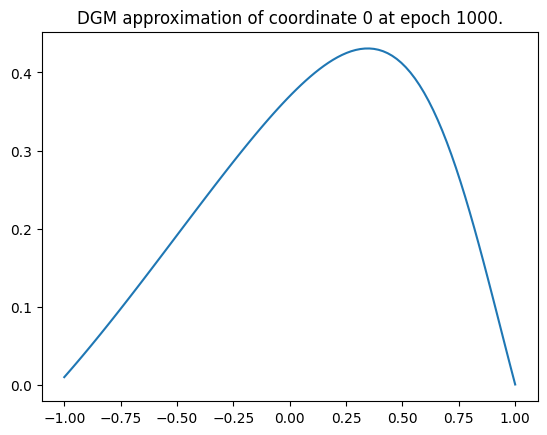

Epoch 1000 with loss 0.32370448112487793


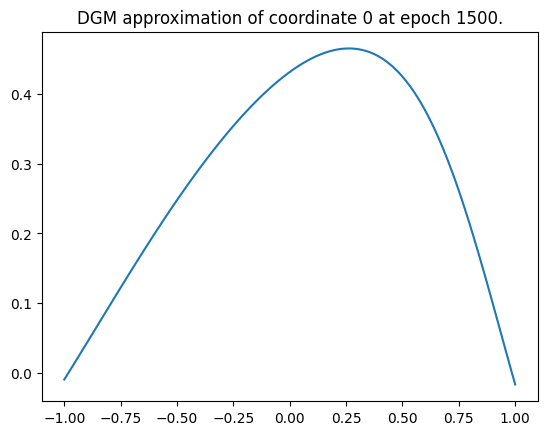

Epoch 1500 with loss 0.27641797065734863


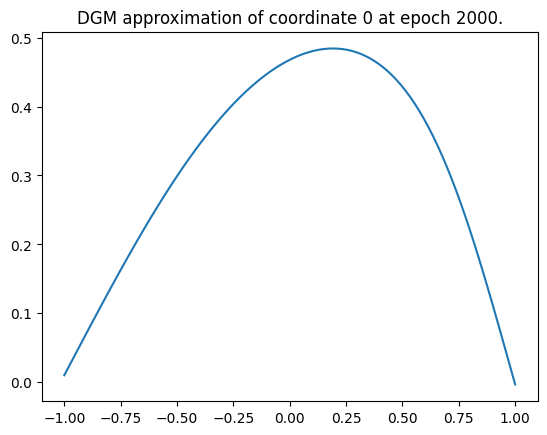

Epoch 2000 with loss 0.28474897146224976


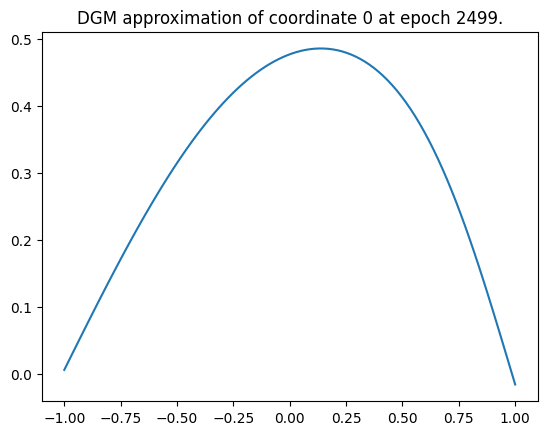

Epoch 2499 with loss 0.24692244827747345
Training of neural network with 2500 epochs take 482.3252878189087 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 482 seconds; L1 error: 2.83E-01; L2 error: 1.02E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


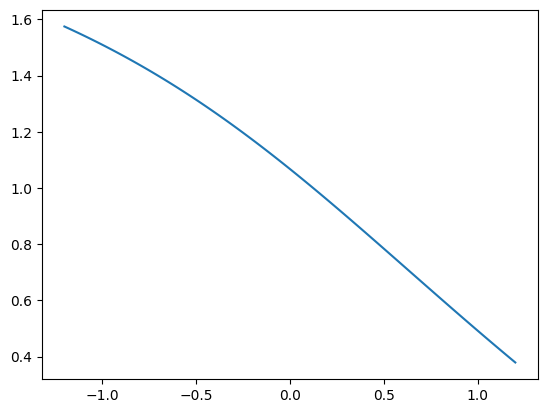

Epoch 0 with loss 1.7570359706878662


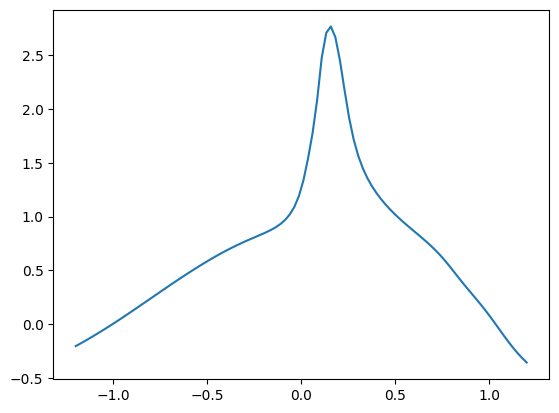

Epoch 500 with loss 0.001942478702403605


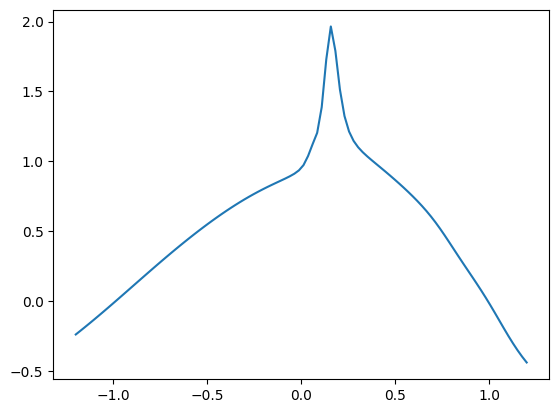

Epoch 1000 with loss 0.000590948504395783


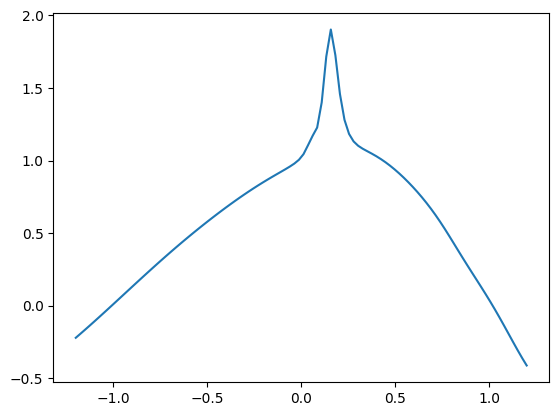

Epoch 1500 with loss 0.0019454730208963156


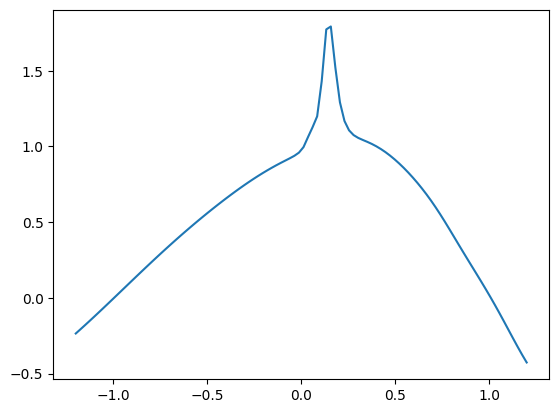

Epoch 2000 with loss 0.00046090182149782777


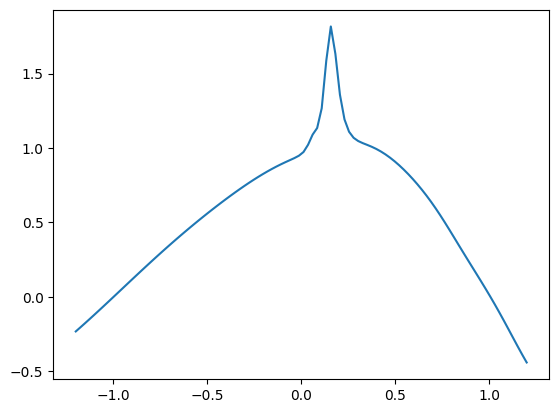

Epoch 2499 with loss 0.0007465146481990814
Training of neural network with 2500 epochs take 137.96104907989502 seconds.
Time taken: 138 seconds; L1 error: 7.51E-02; L2 error: 2.67E-02; rel error: INF.




######## Summary for deep branching method
runtime:        105
fdb runtime:    142
total runtime:  247
mean L1 error:  2.97E-02
std L1 error:   0.00E+00
mean L2 error:  1.24E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        482
mean L1 error:  2.83E-01
std L1 error:   0.00E+00
mean L2 error:  1.02E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        138
mean L1 error:  7.51E-02
std L1 error:   0.00E+00
mean L2 error:  2.67E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


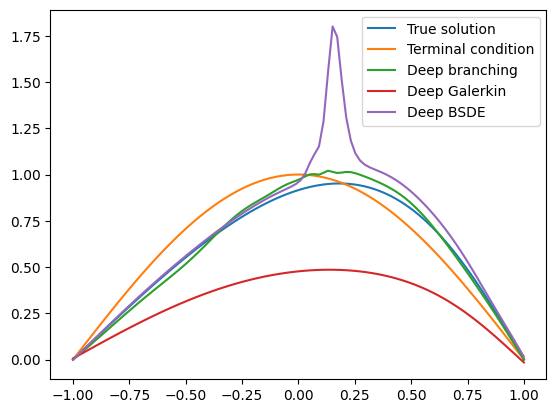

In [15]:
dim = 10
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_1",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)